In [17]:
import requests
import string
from pprint import pprint
import re
import os
import tempfile
from bs4 import BeautifulSoup
from collections import Counter, OrderedDict
from operator import itemgetter
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy.integrate import simps
%matplotlib inline
font = {'family' : 'DejaVu Sans',
        'size'   : 14}
matplotlib.rc('font', **font)
hookRegex = re.compile(r'\[.*\]')
tireRegex = re.compile(r' -')
engnameRegex = re.compile(r'_\(\w+\)')
chars_to_remove = string.punctuation.replace('-', '') + '—„“»«'
api_url = 'http://api.genius.com'
base_url = 'http://genius.com'
headers = {'Authorization': 'Bearer ' + open('./.bearer_token.txt', 'r').read().rstrip('\n')}

In [18]:
def remove_unnecessary(textfile):
    return tireRegex.sub('', hookRegex.sub('',textfile).translate(str.maketrans('','',chars_to_remove)))

class Artist(object):
    artist_id = ''
    songlist = []
    artist_name = ''
    def __init__(self, name, artist_id=False, write_id=False):
        self.name = name
        if artist_id:
            self.artist_id = artist_id
        else:
#             print("Finding the ID of an artist " + self.name)
            search_url = api_url + '/search'
            data = {'q': self.name}
            response = requests.get(search_url, params=data, headers=headers)
            self.artist_id = response.json()['response']['hits'][0]['result']['primary_artist']['api_path']
#         print("ID of an artist " + self.name + " is " + self.artist_id[9:])
        self.artist_name = response.json()['response']['hits'][0]['result']['primary_artist']['name']
        
        if write_id:
            with open('./artists_id_list.txt', 'r+') as textfile:
                if self.artist_id in textfile.read():
                    pass
                else:
                    textfile.write(textfile.read() + '\n' + self.artist_name + "  -  " + self.artist_id)
                    
        list_of_songs = []
#         print("Getting the list of songs")
        for page in range(1,4):
            res = requests.get(api_url + self.artist_id + '/songs?sort=popularity&per_page=50&page=' + str(page), headers=headers)
#             print("Going through page " + str(page))
            for song in res.json()['response']['songs']:
                if ("Ft." in song['full_title']) | ("Remix" in song['full_title']):
                    pass
#                     print(song['full_title'] + " is a feat, skipping")
                else:
                    song_url = song['url']
                    list_of_songs.append(song_url)
        self.songlist = list_of_songs
    
    def perform_task(self):
        with open("./lyrics/" + self.artist_name.replace(' ', '_') + '_lyrics.txt', 'w') as lyricsfile:
            for song in self.songlist:
#                 print(str(self.songlist.index(song)) + " Now scraping " + song[19:])
                page_url = song
                res = requests.get(page_url, headers=headers)
                res.text
                page = requests.get(page_url)
                html = BeautifulSoup(page.text, 'html.parser')
                lyrics = html.find(class_='lyrics').get_text()
                lyricsfile.write(remove_unnecessary(lyrics.lower()))
        return



In [19]:
def get_percentage(words, total):
    return float(words)*100/float(total)

def ord_dict(input_dict):
    return OrderedDict(sorted(input_dict.items(), key = itemgetter(1), reverse = True))

class Lyric_file(object): 
    the_text = ''
    the_list = []
    the_counter = {}
    the_total_words = 0
    the_total_diff_words = 0
    artist_name = ''
    def __init__(self, location):
        self.location = location
        self.the_text = open(self.location, 'r').read()
        self.the_list = self.the_text.split()
        self.the_counter = Counter(self.the_list)
        self.the_total_words = len(self.the_list)
        self.the_total_diff_words = len(self.the_counter)
        self.artist_name = engnameRegex.sub('', location[13:-11]).replace('_', ' ')
        
    def get_most_common(self, number):
        res_dict = {}
        for item in self.the_counter.most_common(number):
            res_dict[item[0]] = item[1]
        return res_dict
    
    def get_most_common_percentage(self, number):
        res_dict = {}
        for word in self.get_most_common(number):
            res_dict[word] = get_percentage(self.get_most_common(number)[word], self.the_total_words)
        return res_dict
    
    def get_percentage_of_word(self, word):
        return get_percentage(self.the_counter[word],self.the_total_words)
    
    def get_vocab_size(self):
        return len(self.the_list)/self.the_total_diff_words
    def get_percentage_counter(self):
        res_dict = {}
        for item in self.the_counter:
            res_dict[item] = self.get_percentage_of_word(item)
        return res_dict
    def plot_distribution(self, savedname=False, graph_label=False):
        
        y = np.asarray(list(ord_dict(self.the_counter).values()))*100/self.the_total_words
        x = np.arange(self.the_total_diff_words)*100/self.the_total_diff_words
        fig = plt.figure(figsize=(20, 10), dpi=100)
        ax = fig.add_subplot(111)
        
        def find_checks(number):
            res_list = [0]
            for count in range(1,number):
                for item in range(0,len(y)):
                    if np.sum(y[:item])>10*count:
                        res_list.append(item)
                        break
            res_list.append(len(y))
            return res_list
        
        def plot_fill(wh_from, wh_to, color):
            ax.plot(x[wh_from:wh_to], y[wh_from:wh_to], color=color, drawstyle='steps-post')
            ax.fill_between(x[wh_from:wh_to], y[wh_from:wh_to], 0, color=color, step="post", alpha=0.5)
        ylim = 4.5
        xlim = 10
        ax.set_xlim(0, xlim)
        ax.set_ylim(0, ylim)
        rainbow = ['red', 'orange', 'yellow', 'green', 'blue', 'blue', 'purple']
        checkpoints = find_checks(7)
        for number, colour in zip(checkpoints[:-1], rainbow):
            plot_fill(number, checkpoints[checkpoints.index(number)+1]+1, color=colour)
        plt.xticks(np.arange(0, xlim, .2), rotation='vertical', fontsize=10)
        plt.yticks(np.arange(0, ylim, .2), fontsize=10)
        ax.set_ylabel('Percentage of one word %')
        ax.set_xlabel('Percentage of all words %')
        if graph_label:
            fig.suptitle(self.artist_name + " frequency distribution", fontsize=22)
        if savedname:
            plt.savefig('./figs/distributions/' + self.artist_name.replace(' ', "_") + '.png')
        plt.show()

In [20]:
def get_first_ten_k(oldlocation, newlocation):
    oldfile = open(oldlocation, 'r')
    newfile = open(newlocation, 'w')
    l = oldfile.read().split()
    if len(l) > 10000:
        for word in l[:10000]:
            newfile.write(word.replace("ё", "е") + "\n")
        oldfile.close()
        newfile.close()
    else:
        print(oldlocation[:-4] + " has not enough lyrics")
        os.remove(newlocation)
    return

def get_unique_words(total_words, artist_count):
    shared_items = set(total_words.items()) & set(artist_count.items())
    return shared_items

def get_total_file(directory, location):
    with open(location, 'w') as total_file:
        for lyrics in os.listdir(directory):
            total_file.write(open(directory+lyrics, 'r').read())
    return

In [ ]:
### USING THE STUFF CREATED ABOVE, SCRAPE ALL NON-FEAT LYRICS FOR TH ARTISTS IN artists_source.txt

with open('./artists_source.txt', 'r') as id_list:
    artistlist = id_list.readlines()
    for artist in artistlist:
        the_artist = Artist(artist.rstrip("\n"), write_id=True)
        print("Now scraping " + the_artist.artist_name + ", " + str(len(artistlist) - 1 - artistlist.index(artist)) + " remaining")
        the_artist.perform_task()

In [ ]:
for file in os.listdir('./lyrics/'):
    get_first_ten_k('./lyrics/' + file, './cut_lyrics/' + file)

get_total_file('./cut_lyrics/', './total_cut.txt')
get_total_file('./lyrics/', './total.txt')

In [21]:
def plot_barchart(input_dict, savedname, y_label=False, graph_label=False):
    fig = plt.figure(figsize=(20, 20), dpi=100)
    ax = fig.add_subplot(111)
    ind = np.arange(len(input_dict))                # the x locations for the groups
    width = 0.70                      # the width of the bars

    rects1 = ax.bar(ind, input_dict.values(), width,
                    color='#BBBBBB')
    
    for rect, label in zip(rects1, input_dict.values()):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height, str(label), ha='center', va='bottom') 
    if y_label:
        ax.set_ylabel(y_label, fontsize=22)
    if graph_label:
        fig.suptitle(graph_label, fontsize=22)
    ax.set_xticks(ind)
    ax.set_xlim(0-width, len(ind))
    ax.tick_params(axis='both', which='major', labelsize=20)
    xtickNames = ax.set_xticklabels(input_dict.keys(), rotation='vertical')
    plt.savefig(savedname, bbox_inches='tight')
    plt.show()


In [22]:
class File_dir(object):
    file_list = []
    total_lyric = None
    total_counter = None
    def __init__(self, location, total_file):
        self.location = location
        self.total_file = total_file
        
        self.total_lyric = Lyric_file(total_file)
        self.total_counter = self.total_lyric.the_counter
        
        
        res_list = []
        for file in os.listdir(location):
            if "direct" in file:
                continue
            res_list.append(location + file)
        self.file_list = res_list
        return
    
    def get_uniq_words(self):
        res_dict = {}
        for artist in self.file_list:
            obj = Lyric_file(artist)
            res_dict[obj.artist_name] = len(get_unique_words(self.total_counter, obj.the_counter))
        return ord_dict(res_dict)
    
    def get_wordgroup_percentage(self, wordlist):
        res_dict = {}
        for artist in self.file_list:
            obj = Lyric_file(artist)
            total_self_percentage = 0
            for word in wordlist:
                total_self_percentage += obj.get_percentage_of_word(word)
            res_dict[obj.artist_name] = round(total_self_percentage, 2)
        return ord_dict(res_dict)
    def plot_wordgroup(self, wordlist, savedname, y_label=False):
        plot_barchart(self.get_wordgroup_percentage(wordlist),
           savedname, 
           y_label=y_label)
    def plot_uniq_words(self, savedname, y_label=False):
        plot_barchart(self.get_uniq_words(), savedname, y_label=y_label)
    def plot_distributions(self, savedname=False, graph_label=False):
        for artist in self.file_list:
            obj = Lyric_file(artist)
            obj.plot_distribution(savedname=savedname, graph_label=graph_label)
                
cut_dir = File_dir('./cut_lyrics/', './total_cut.txt')

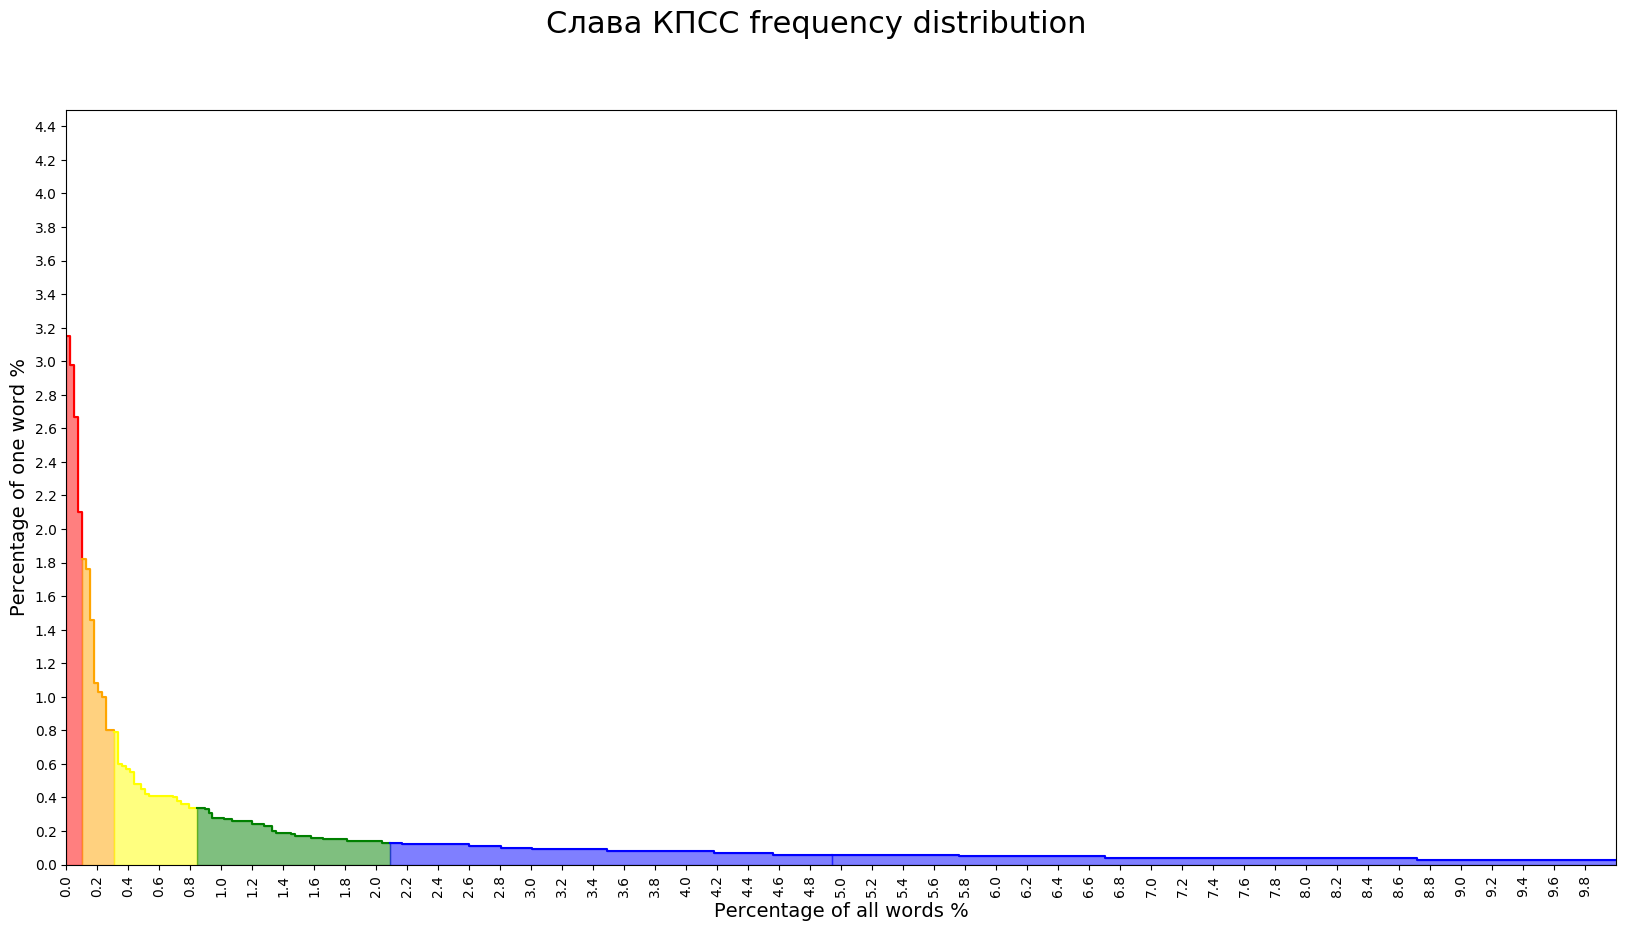

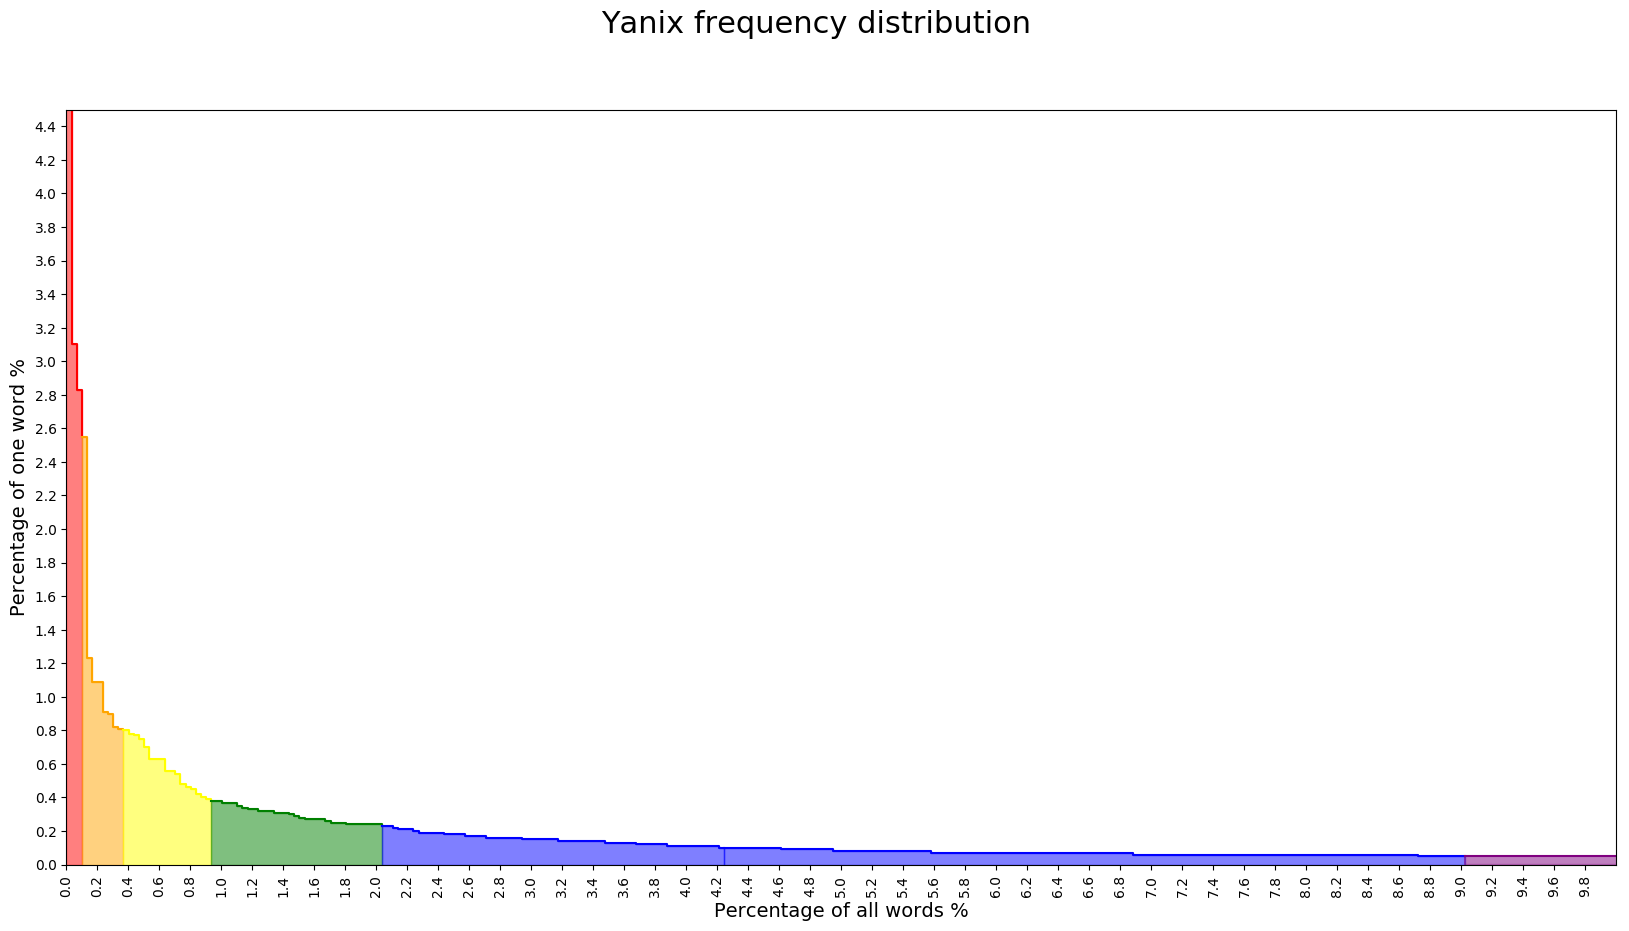

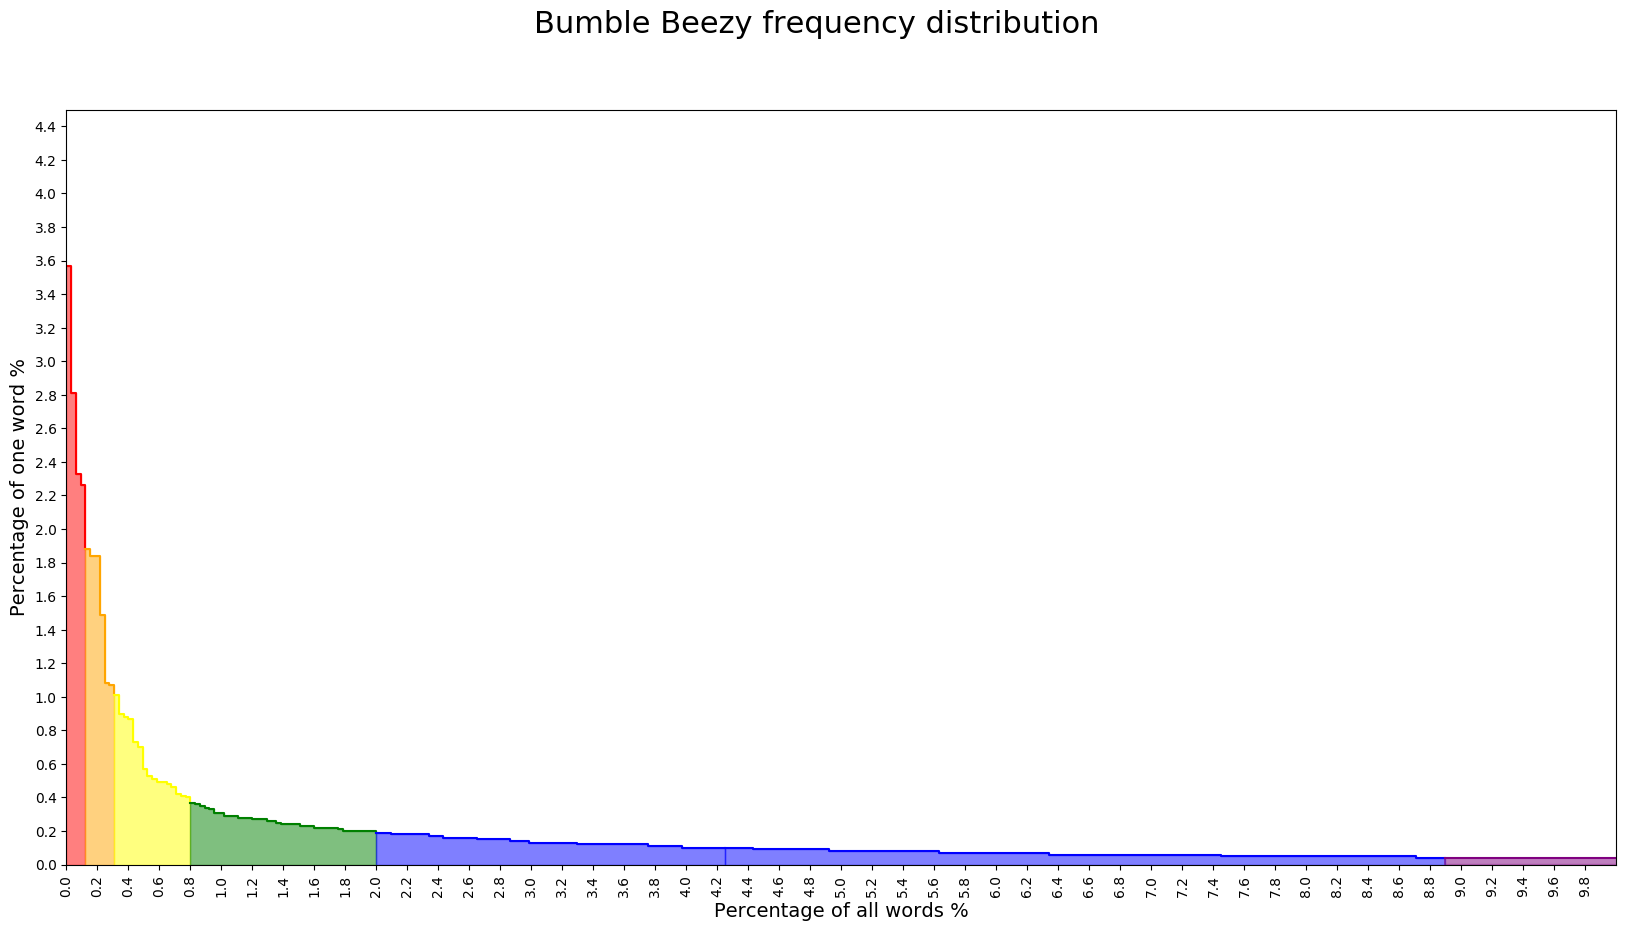

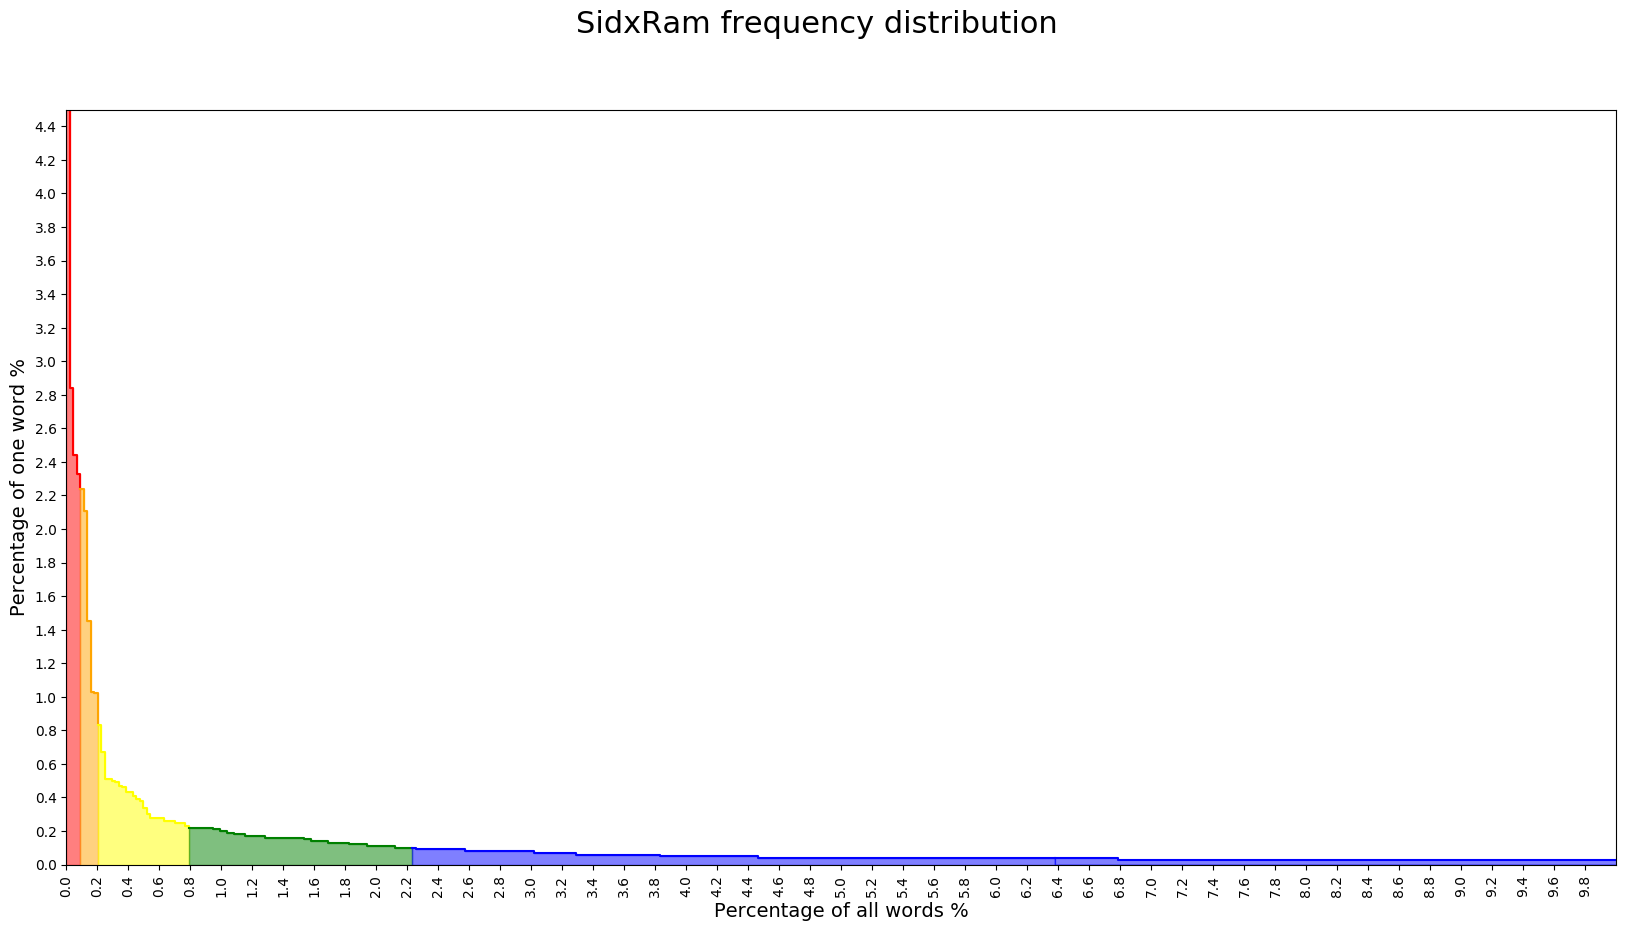

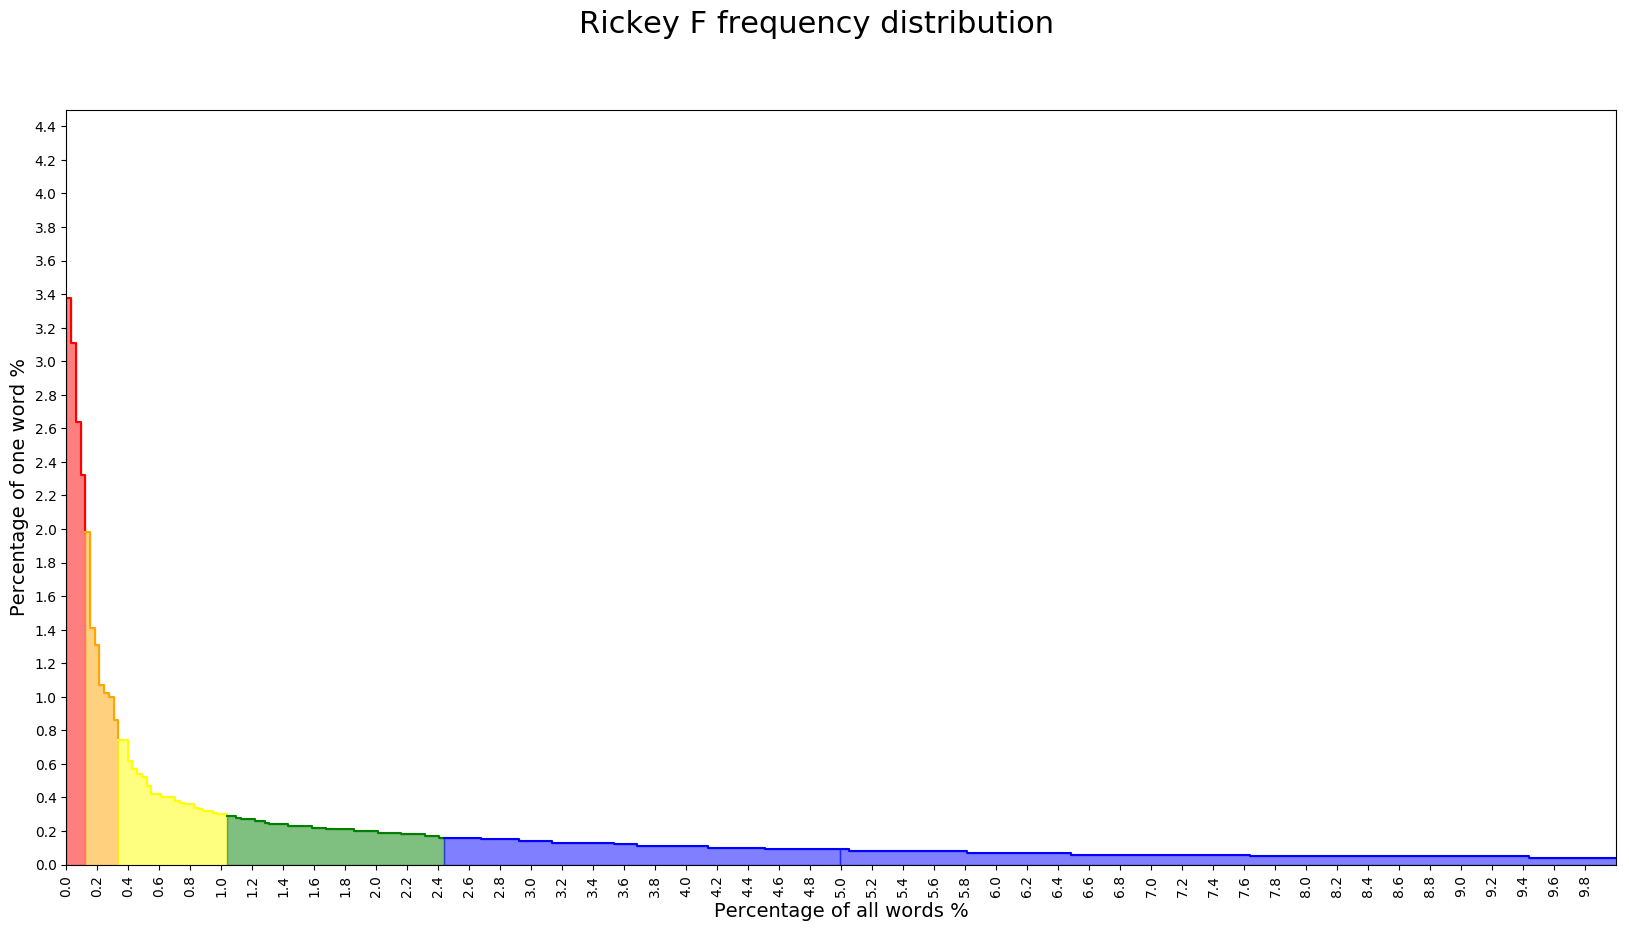

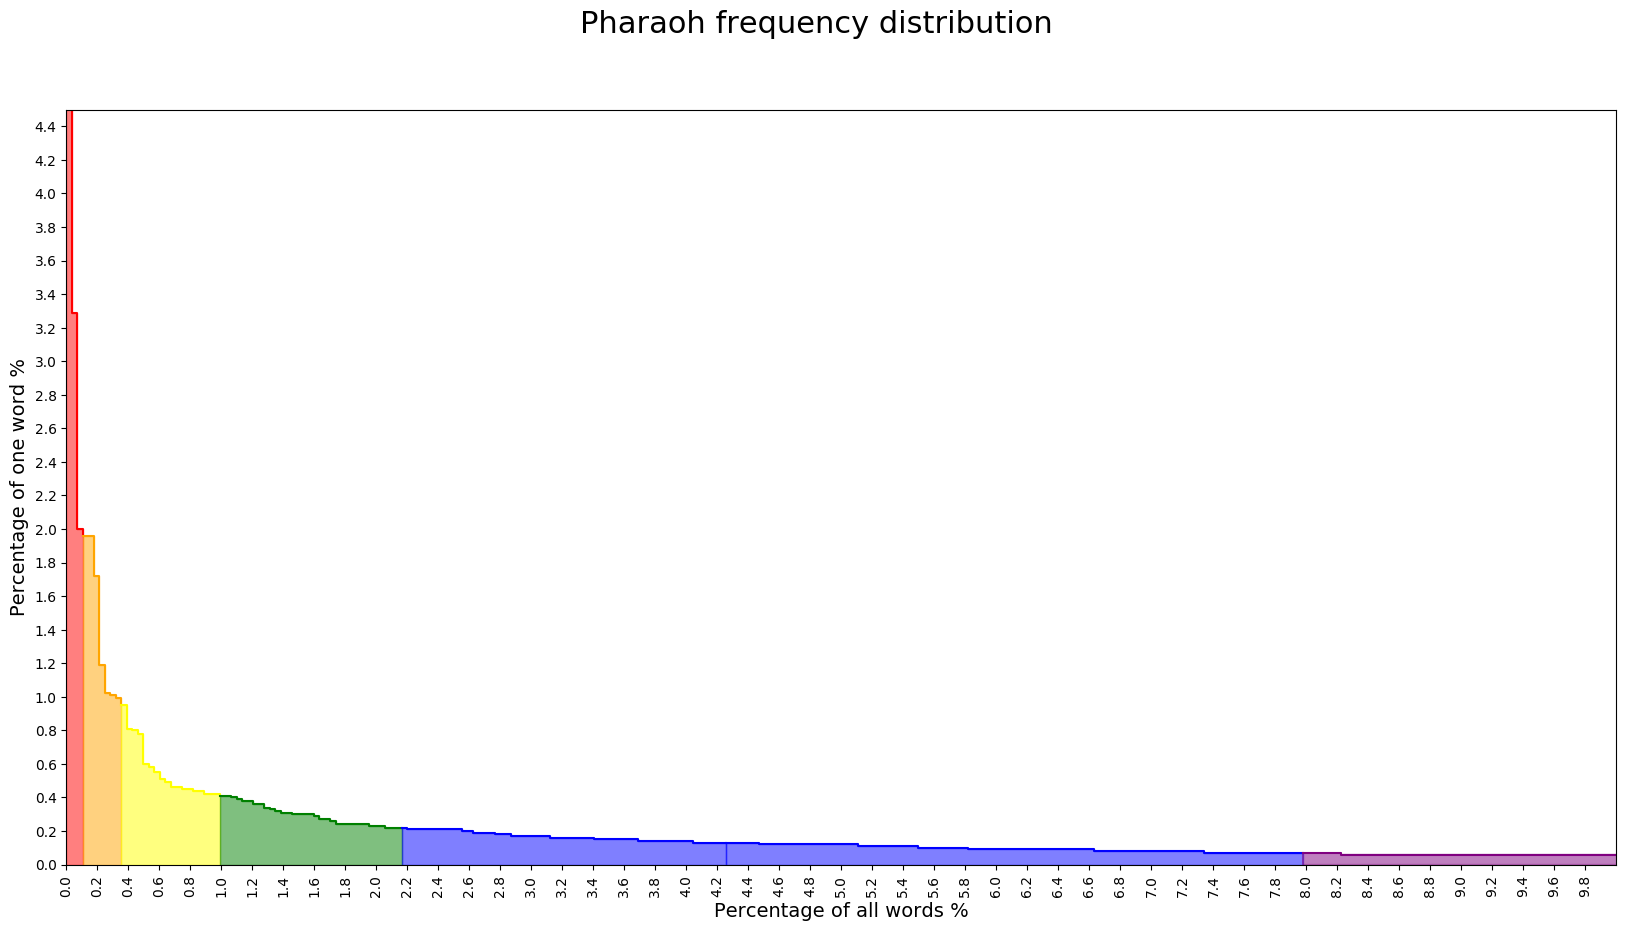

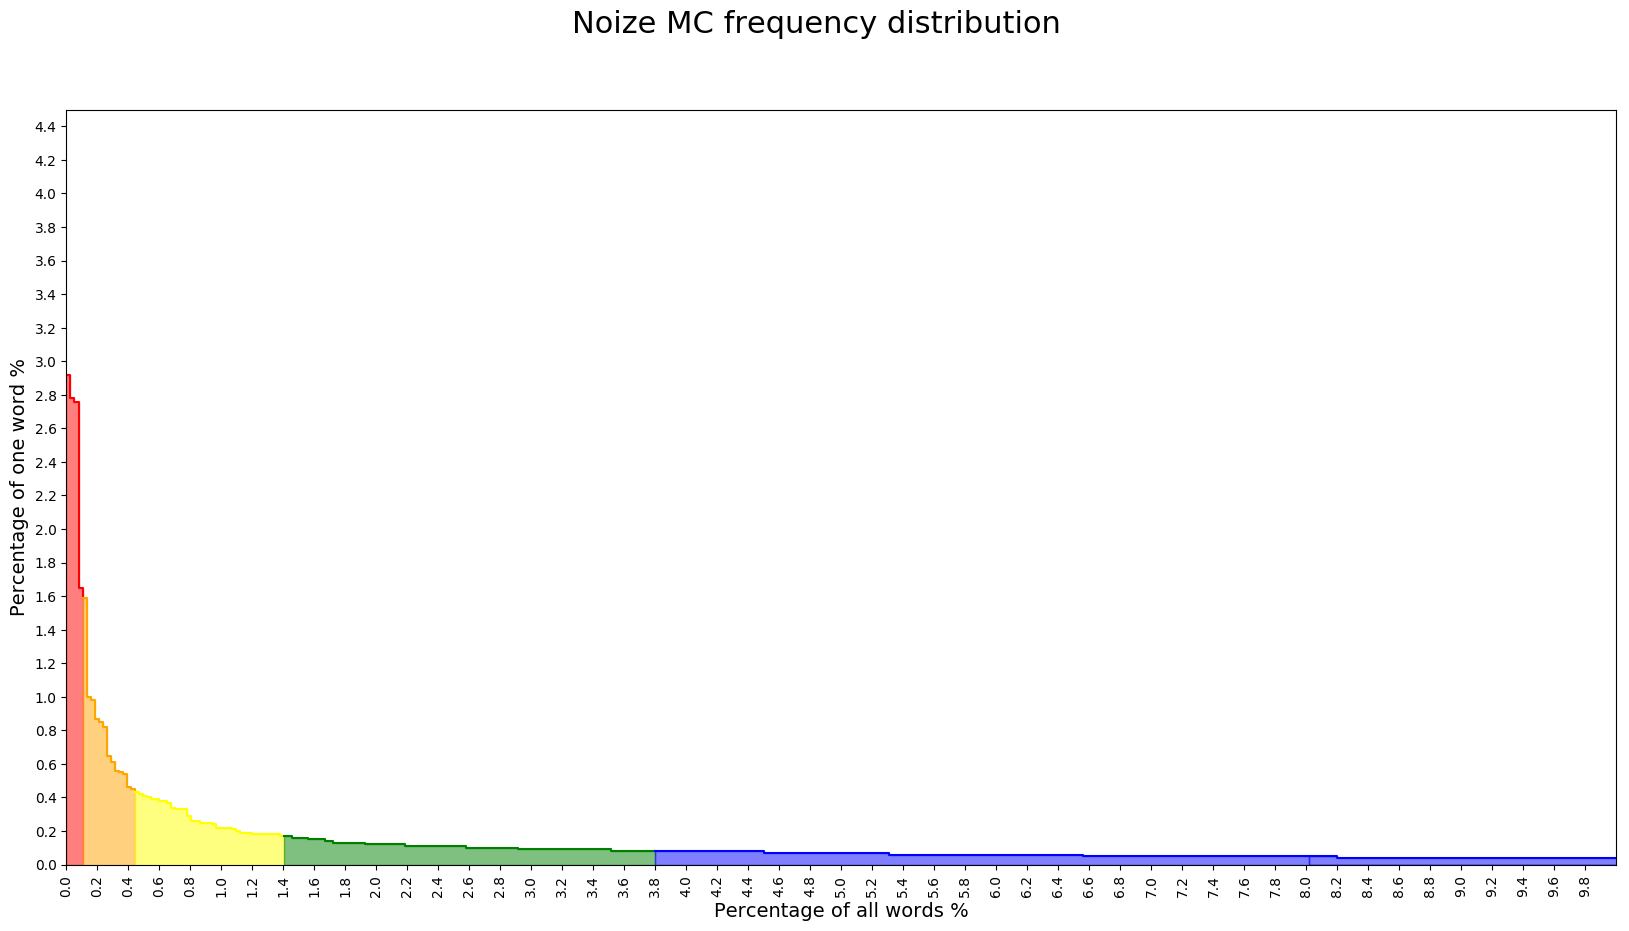

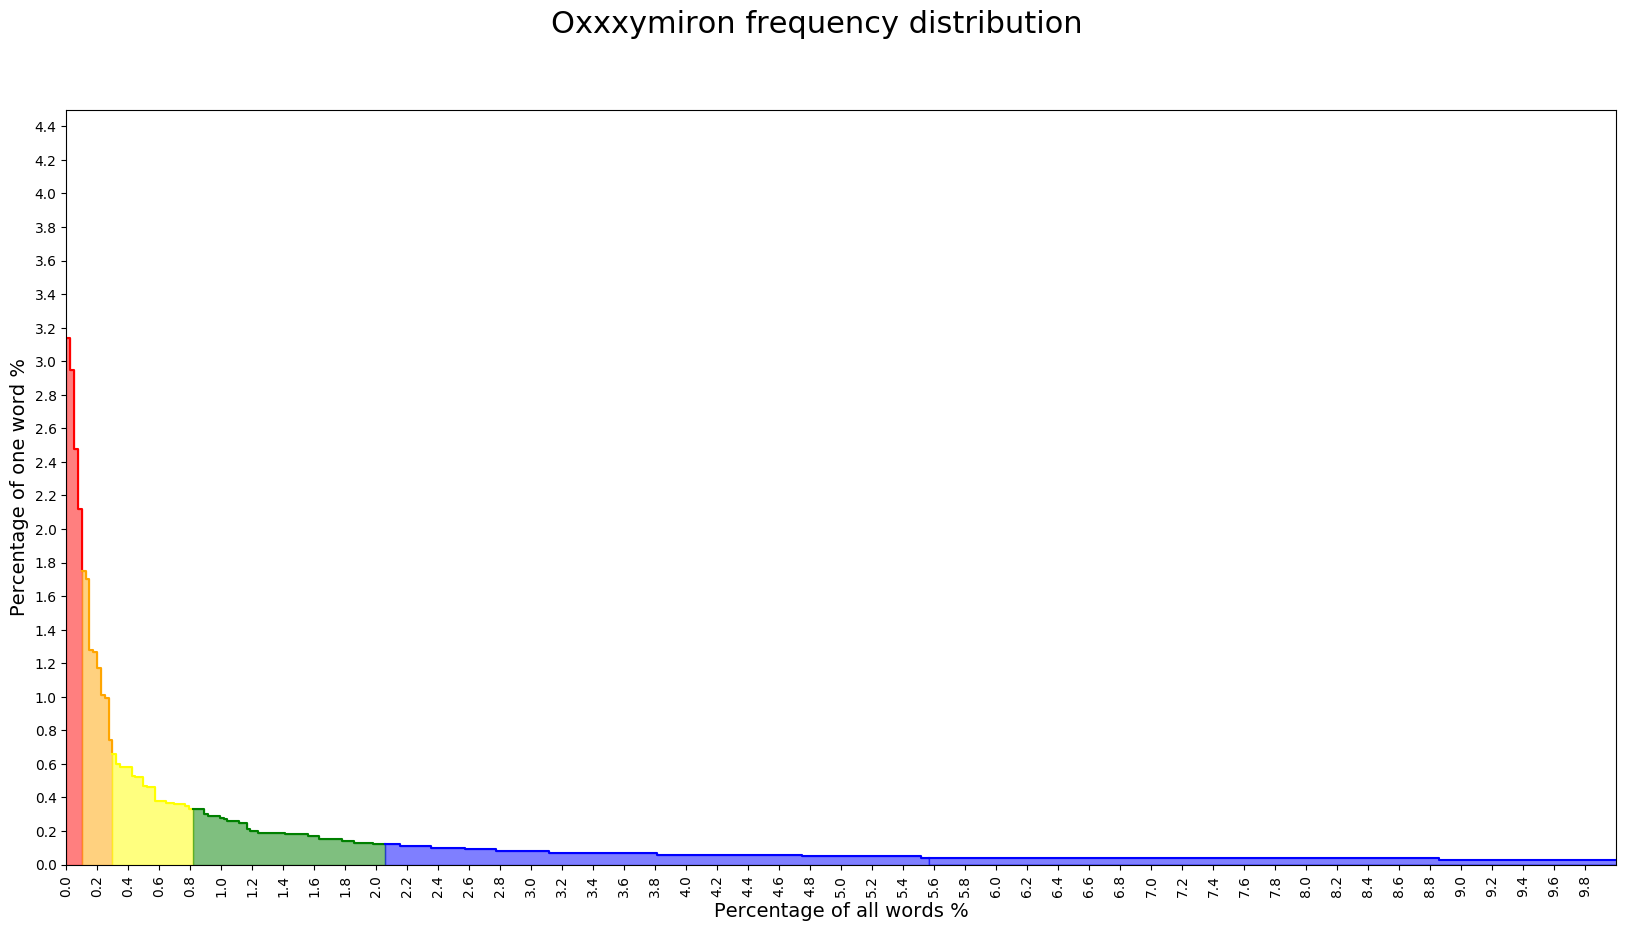

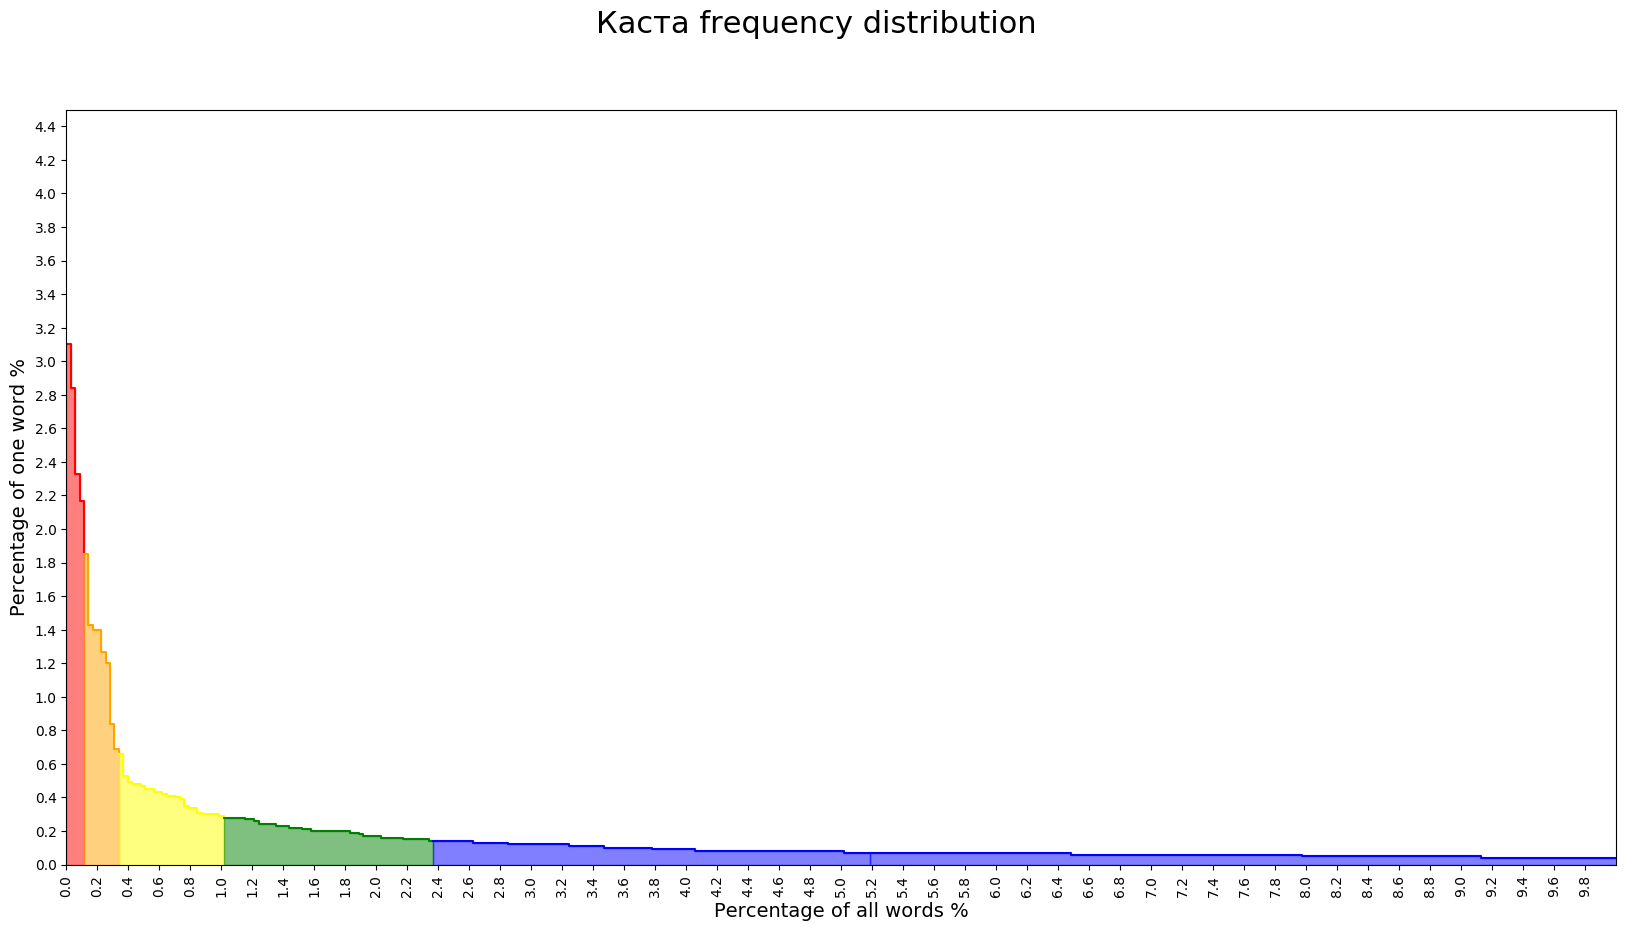

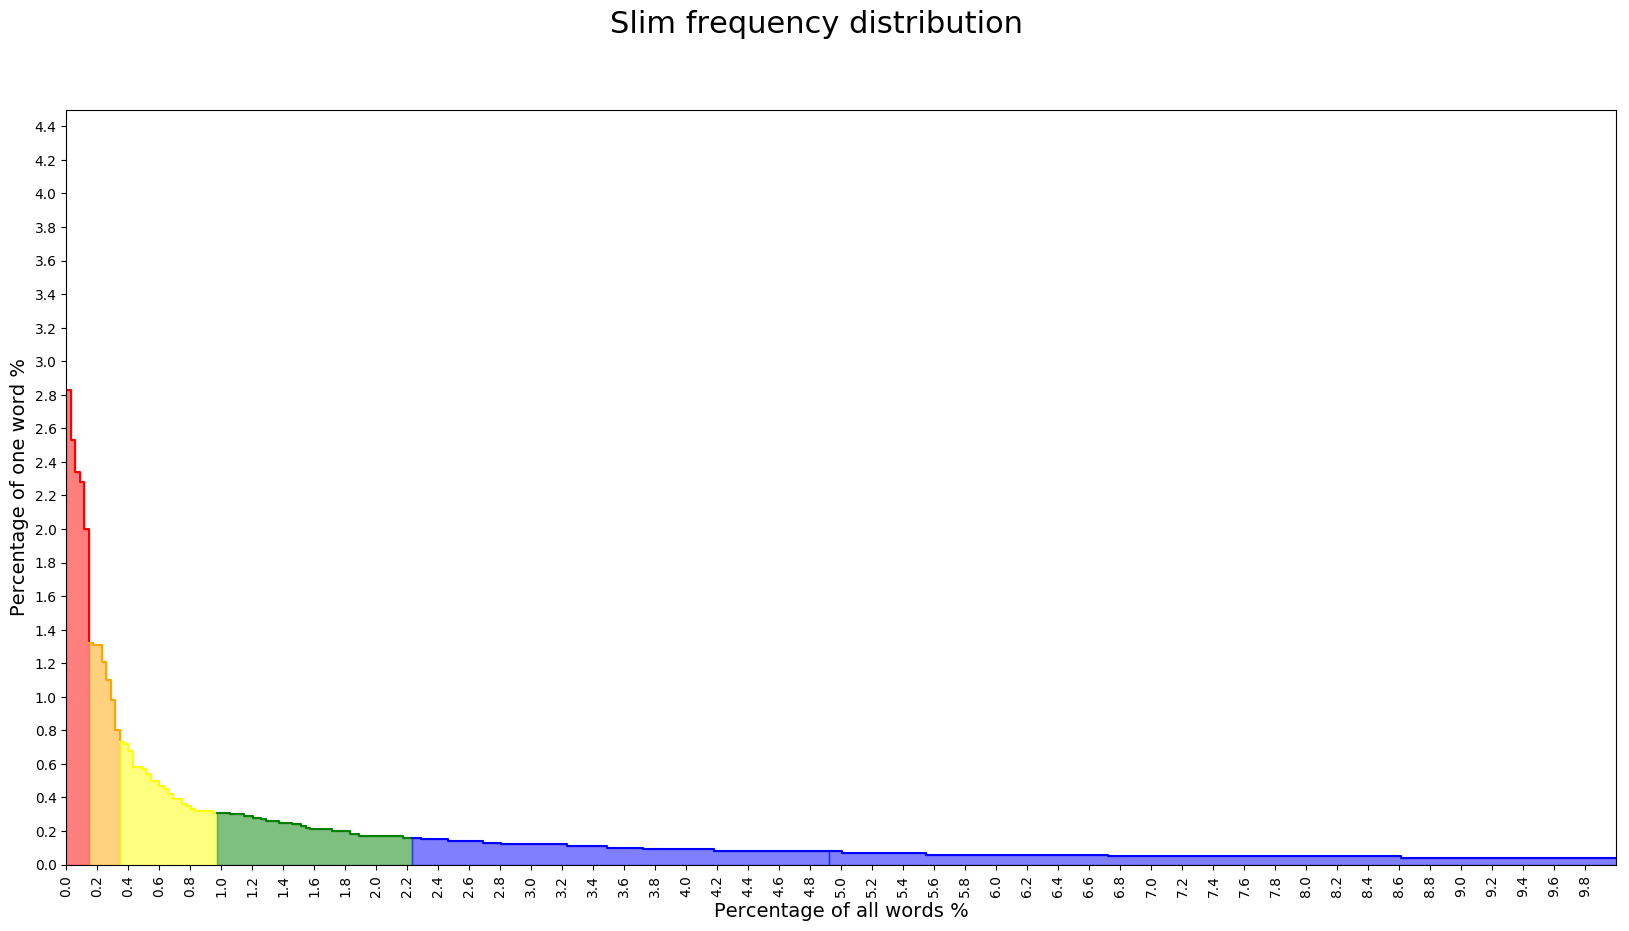

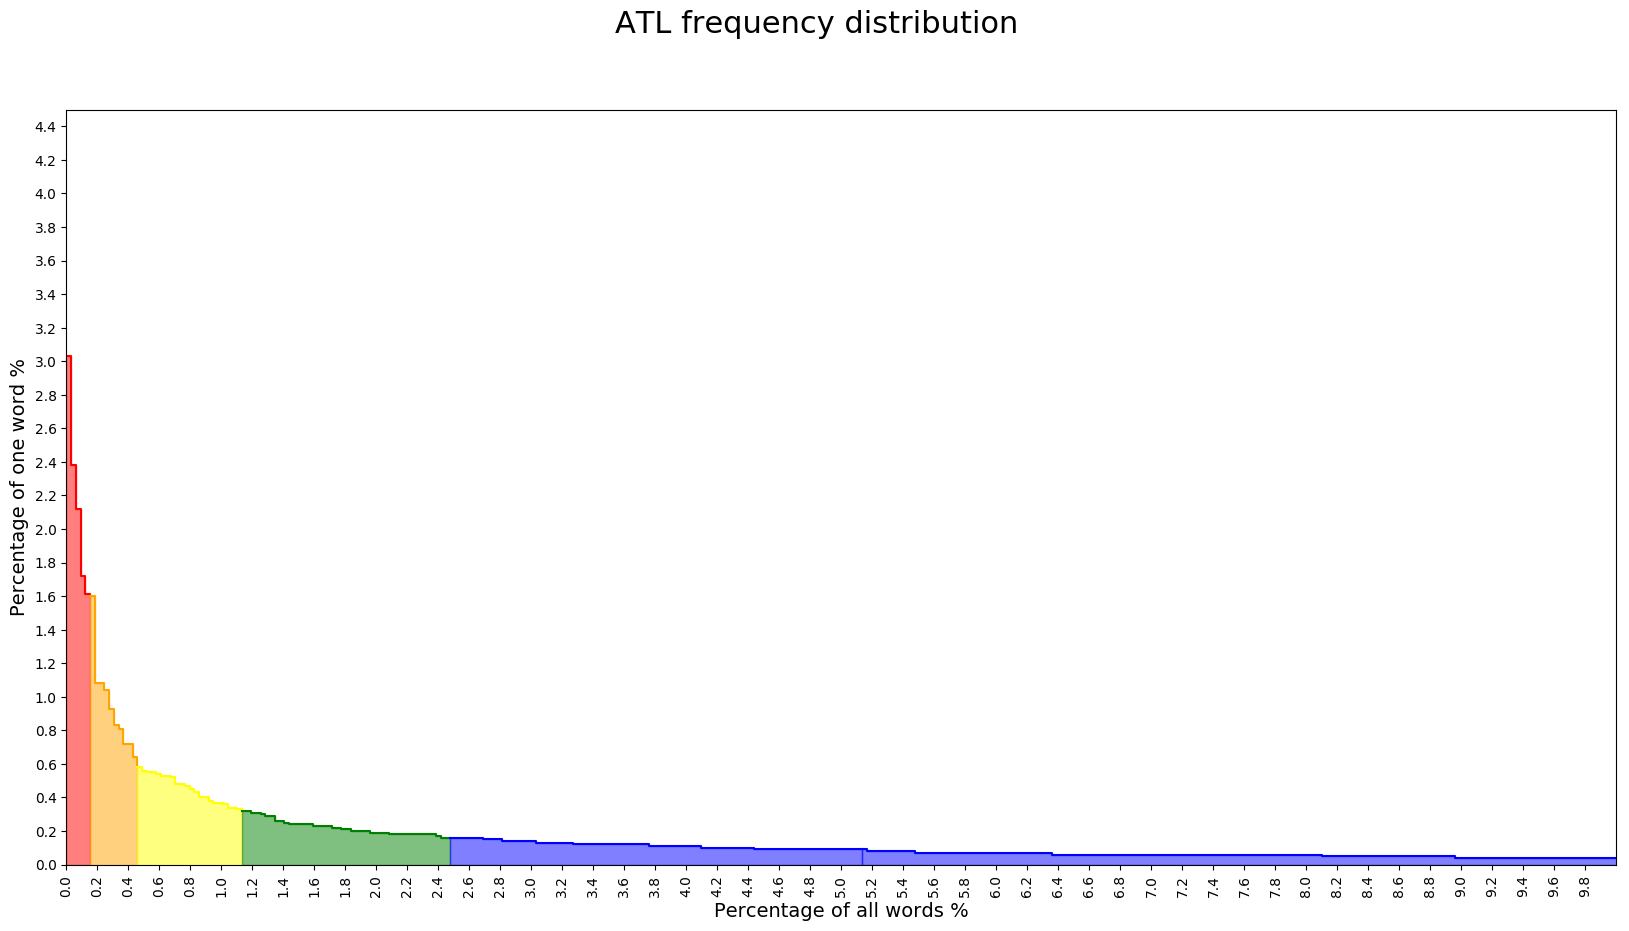

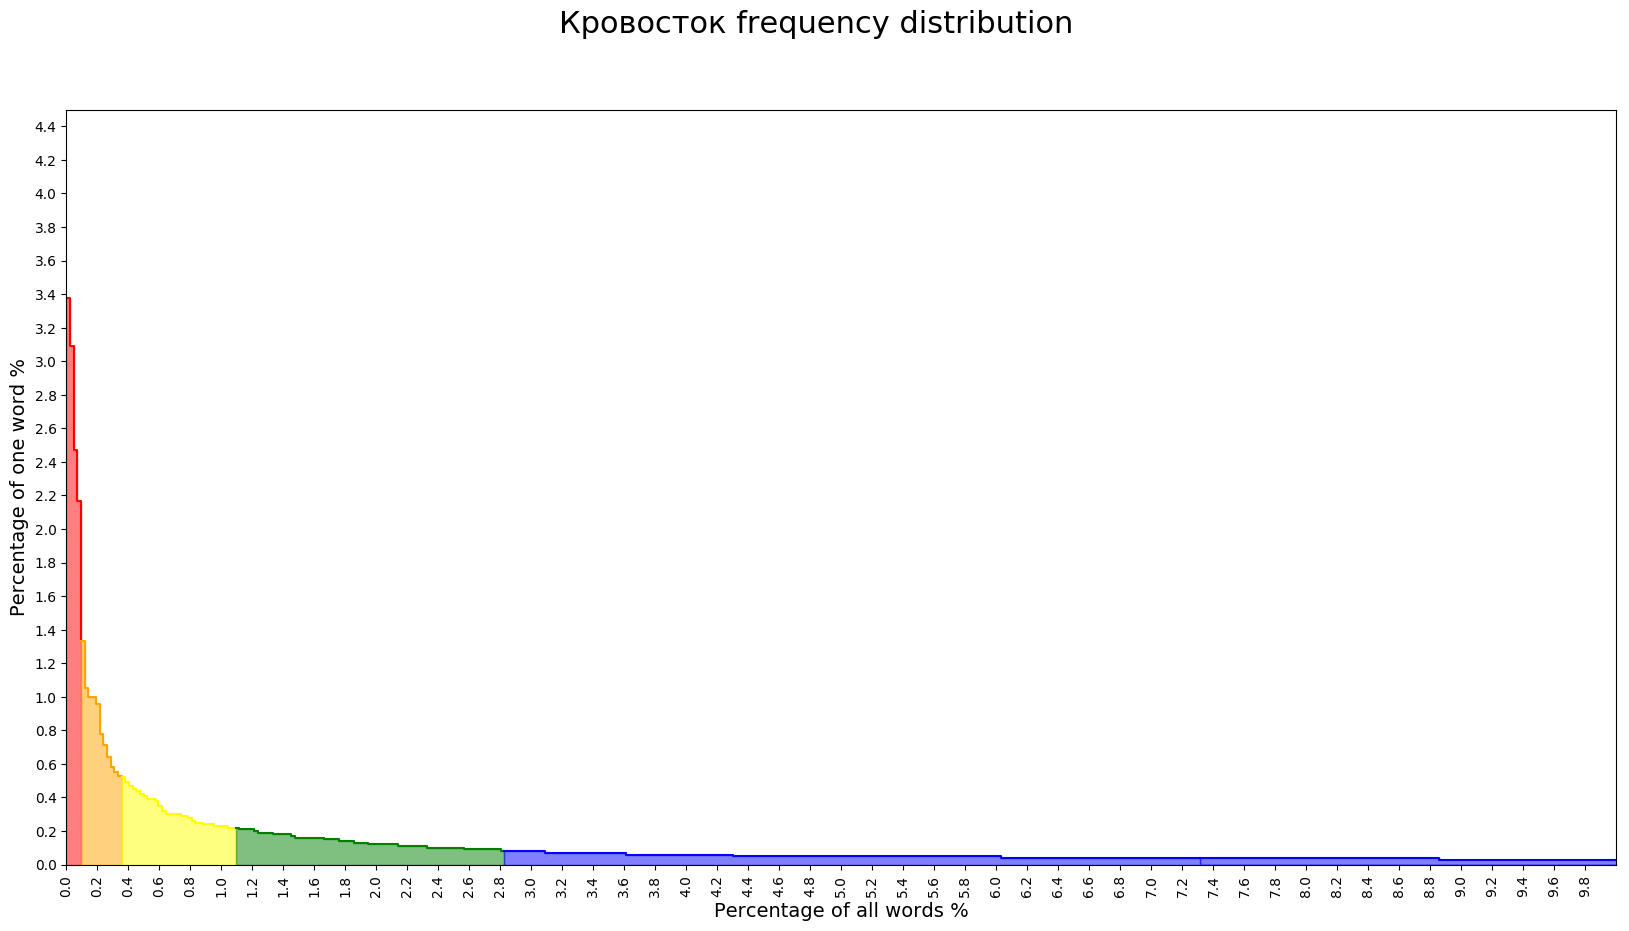

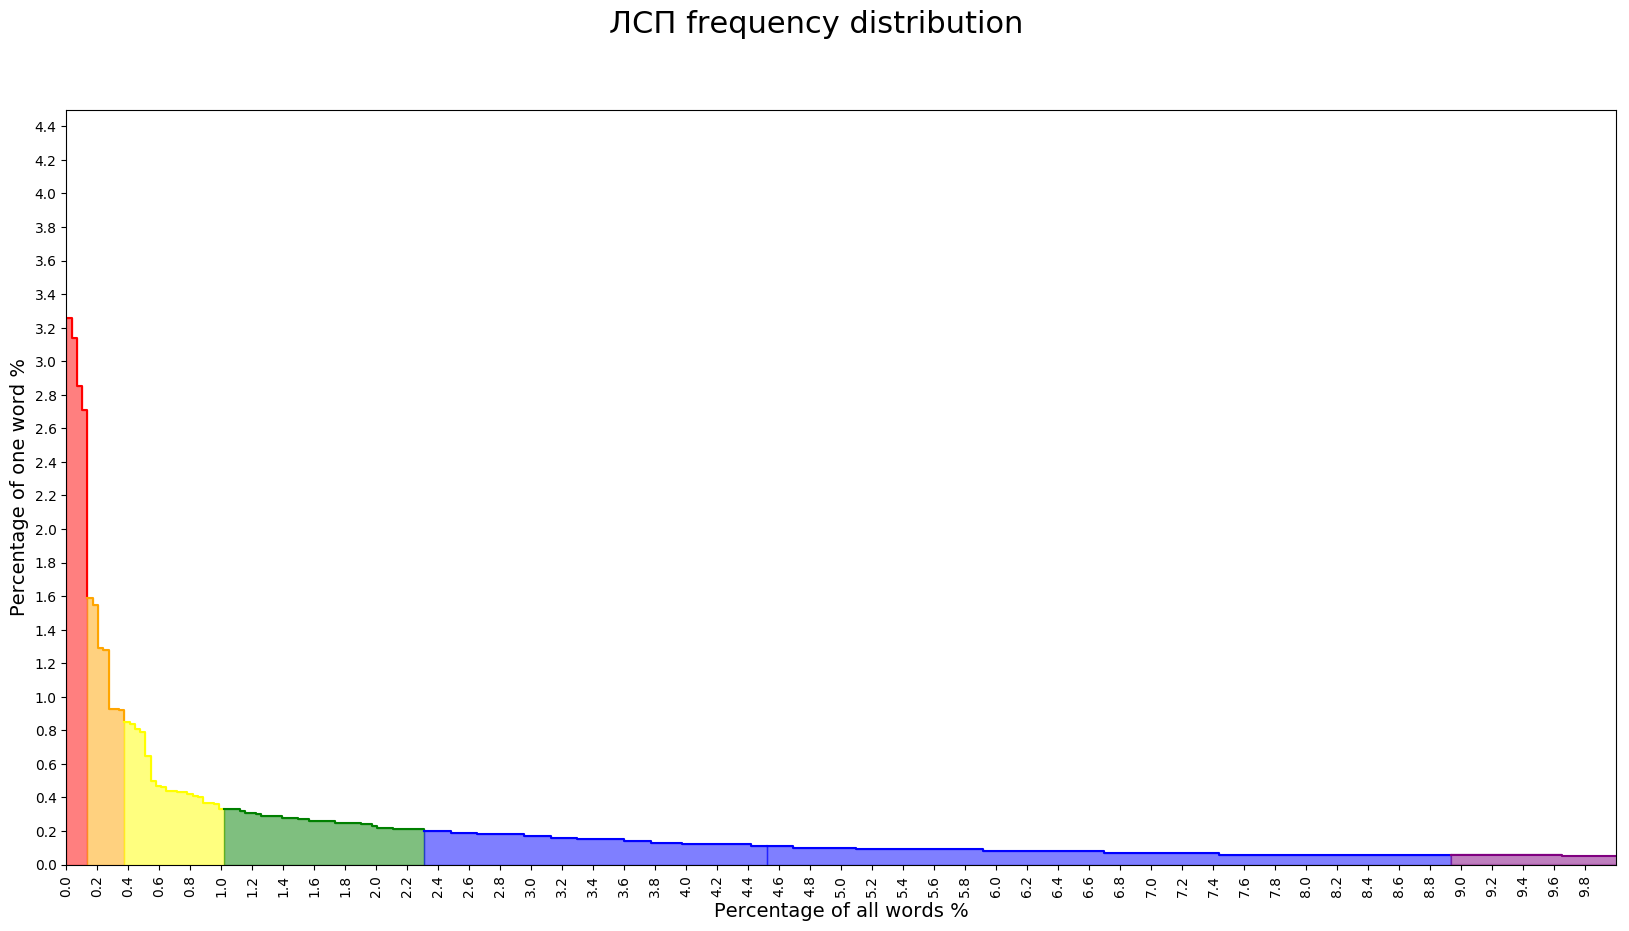

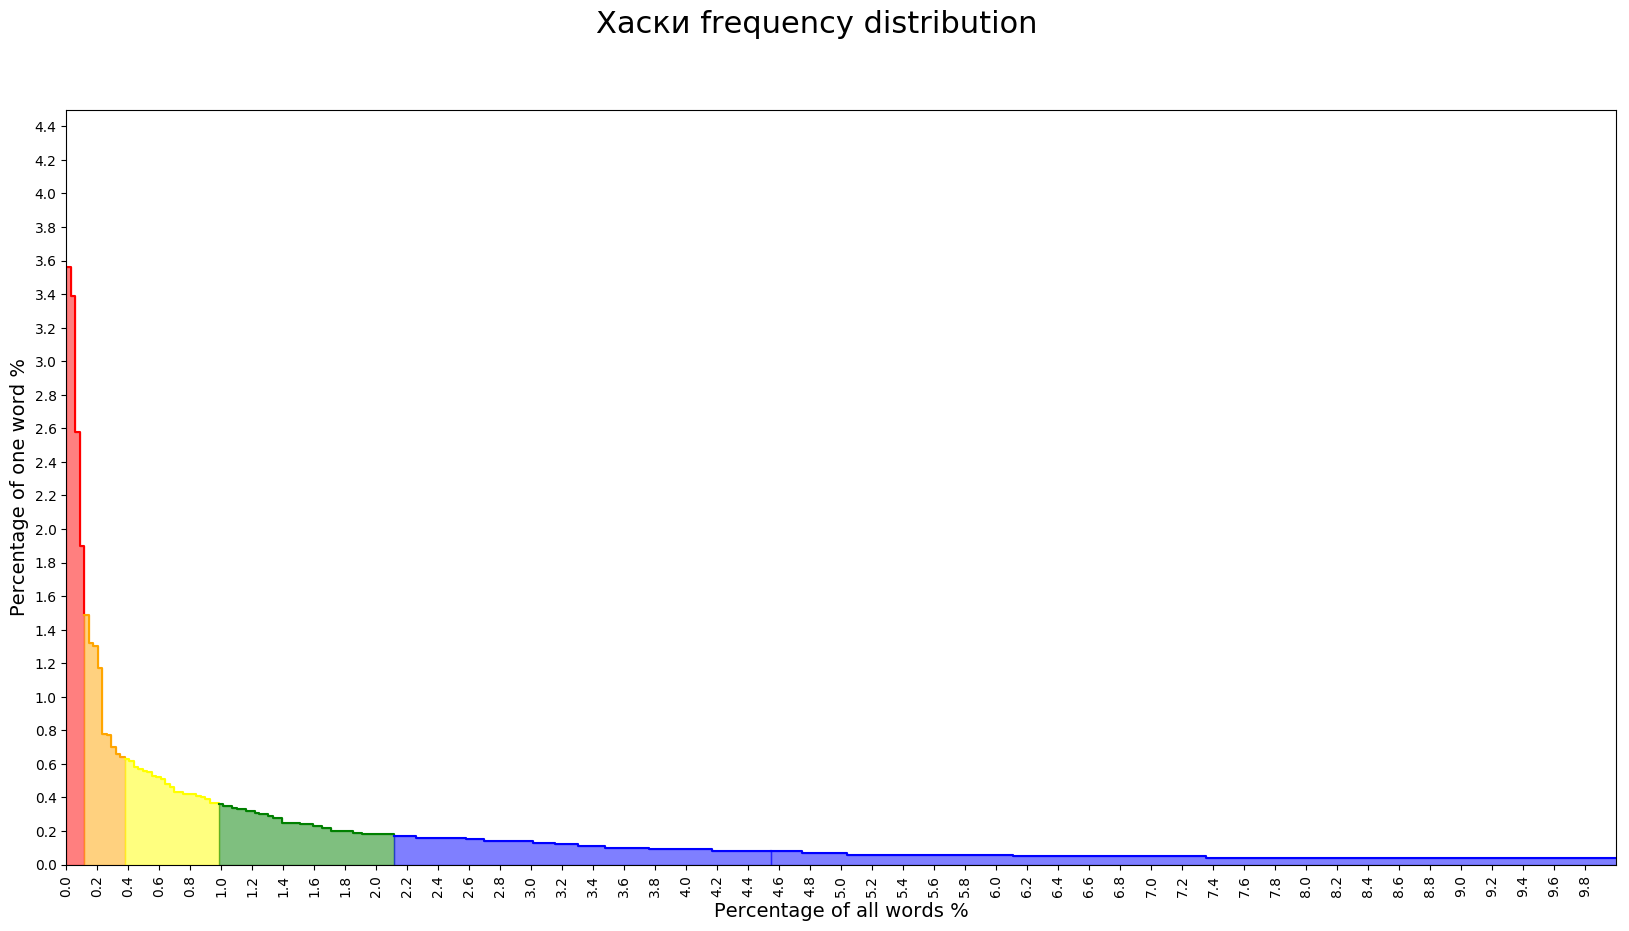

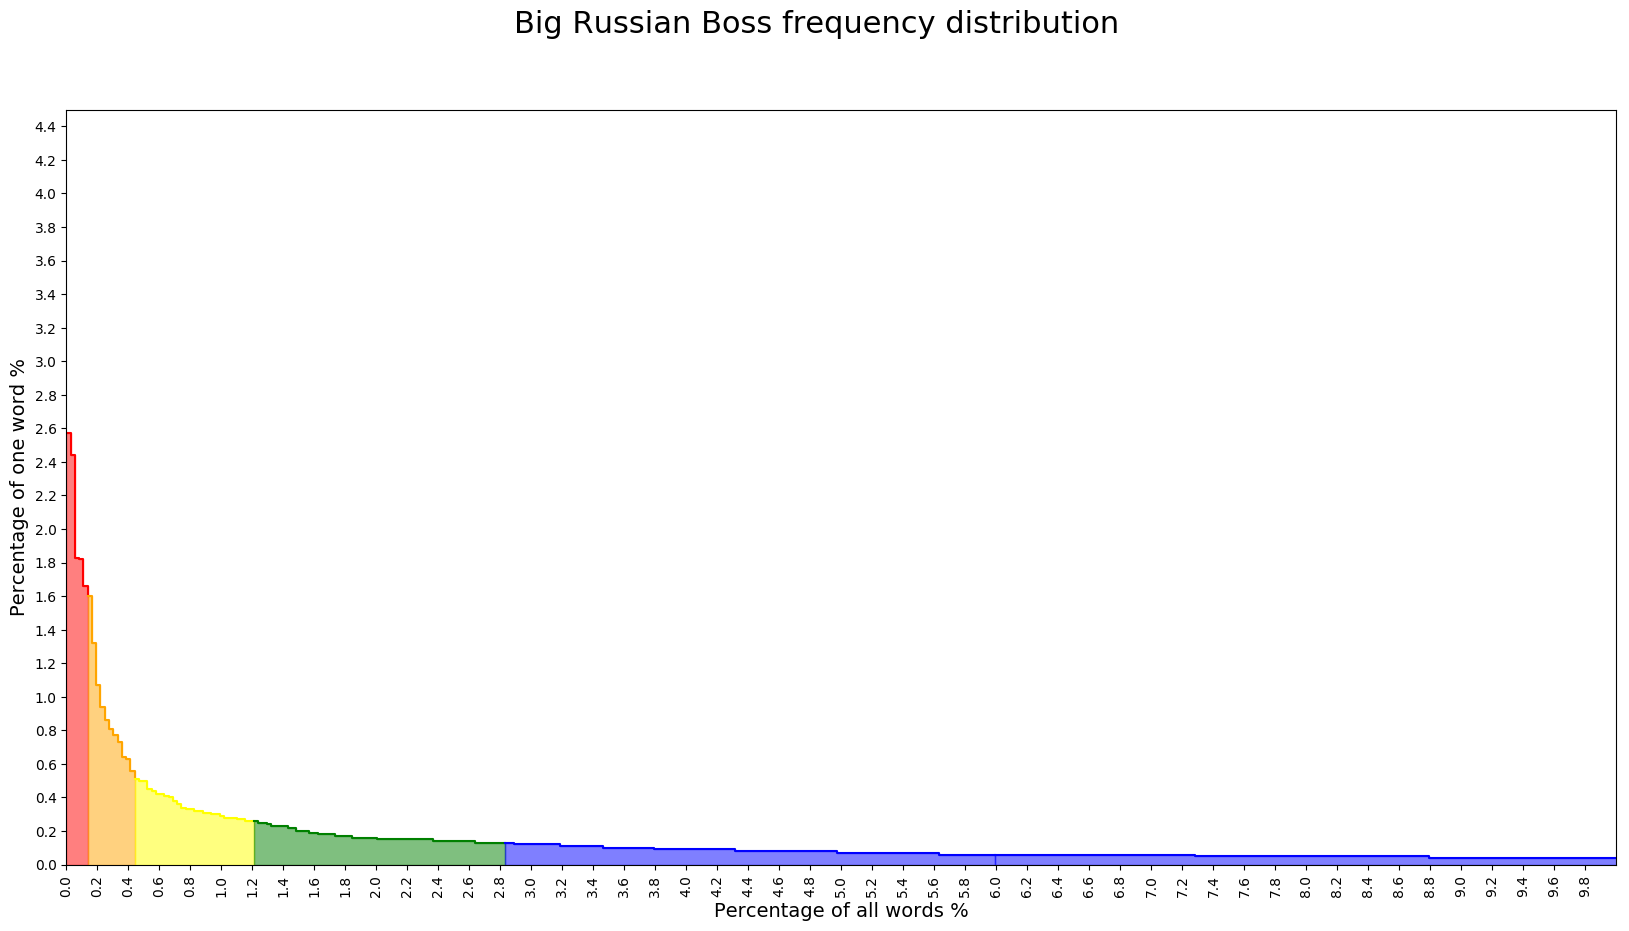

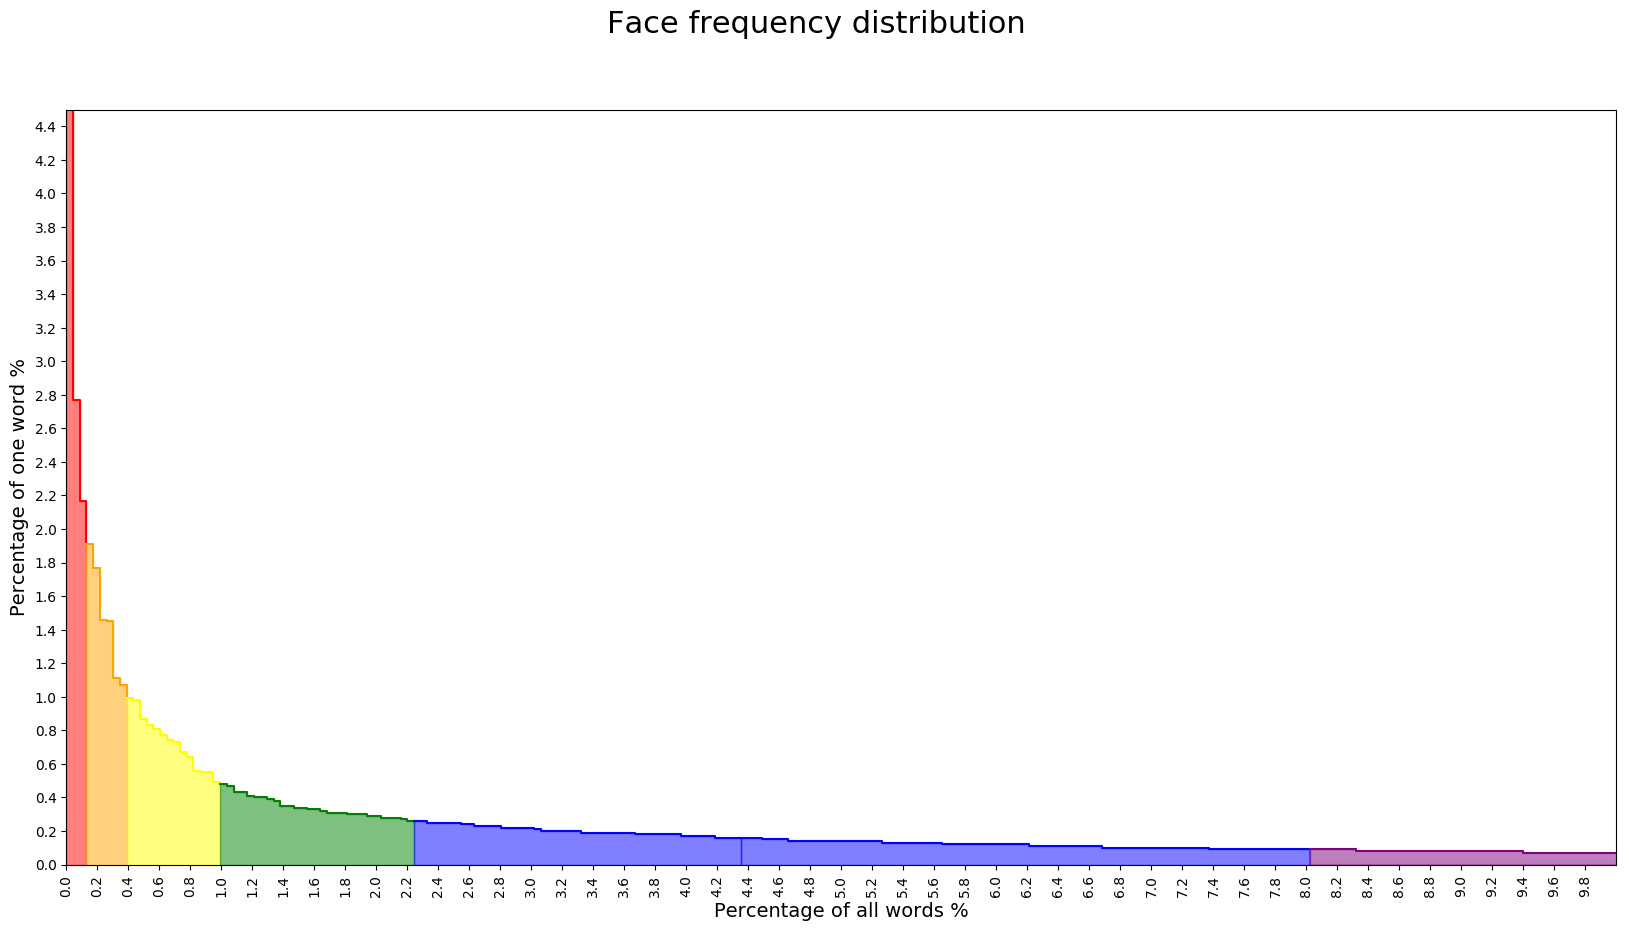

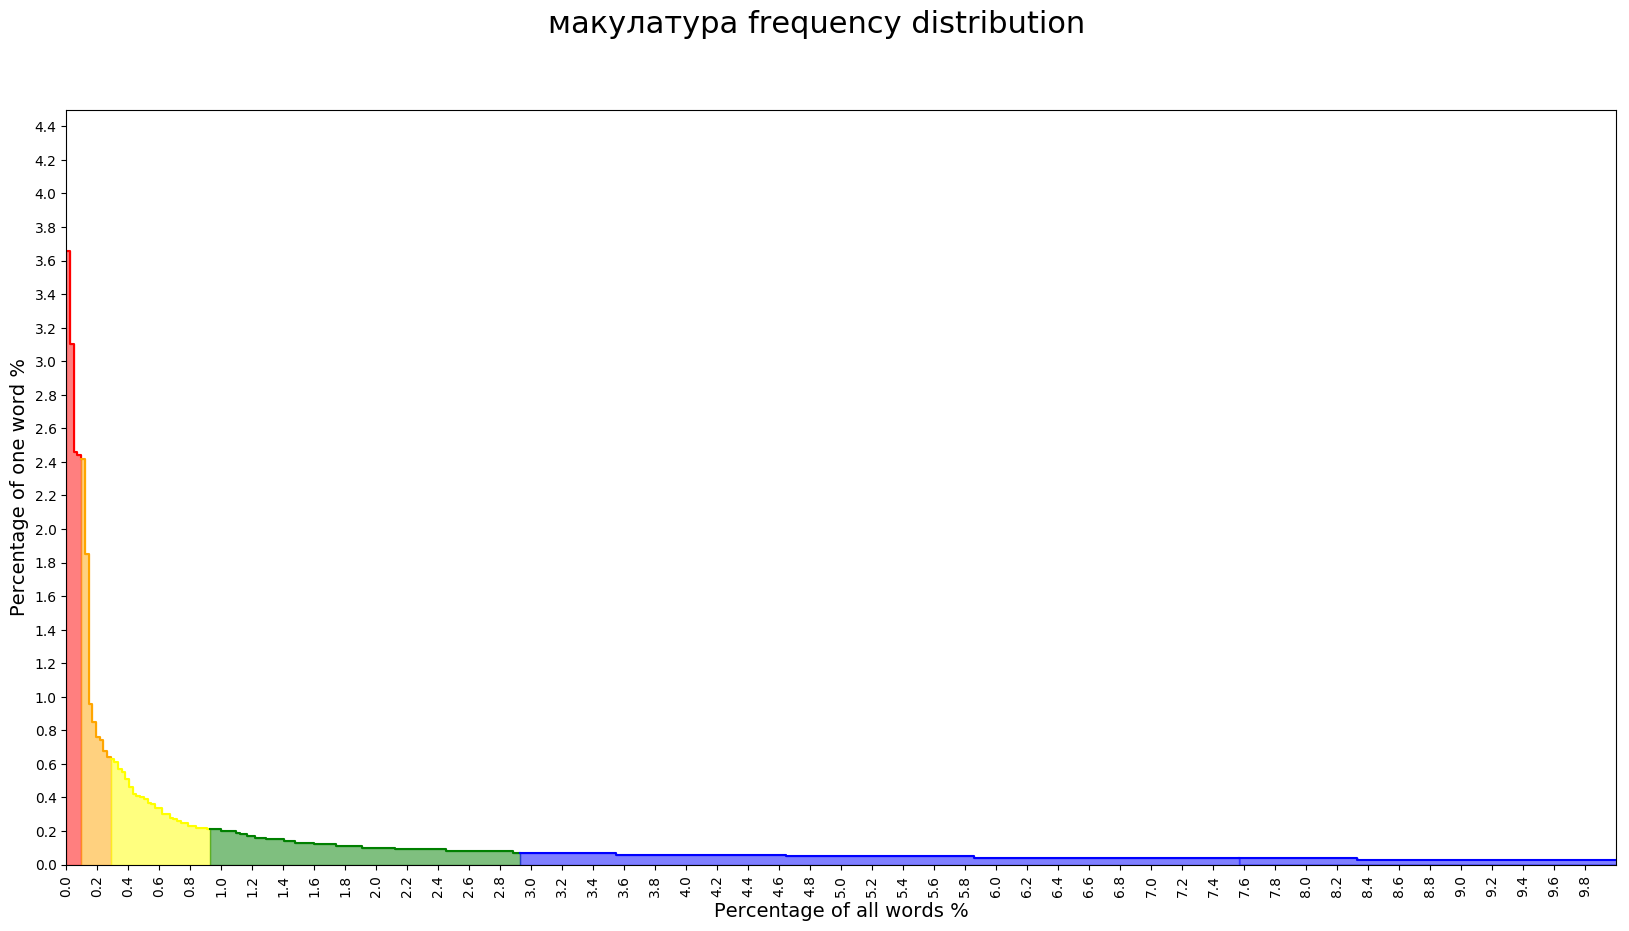

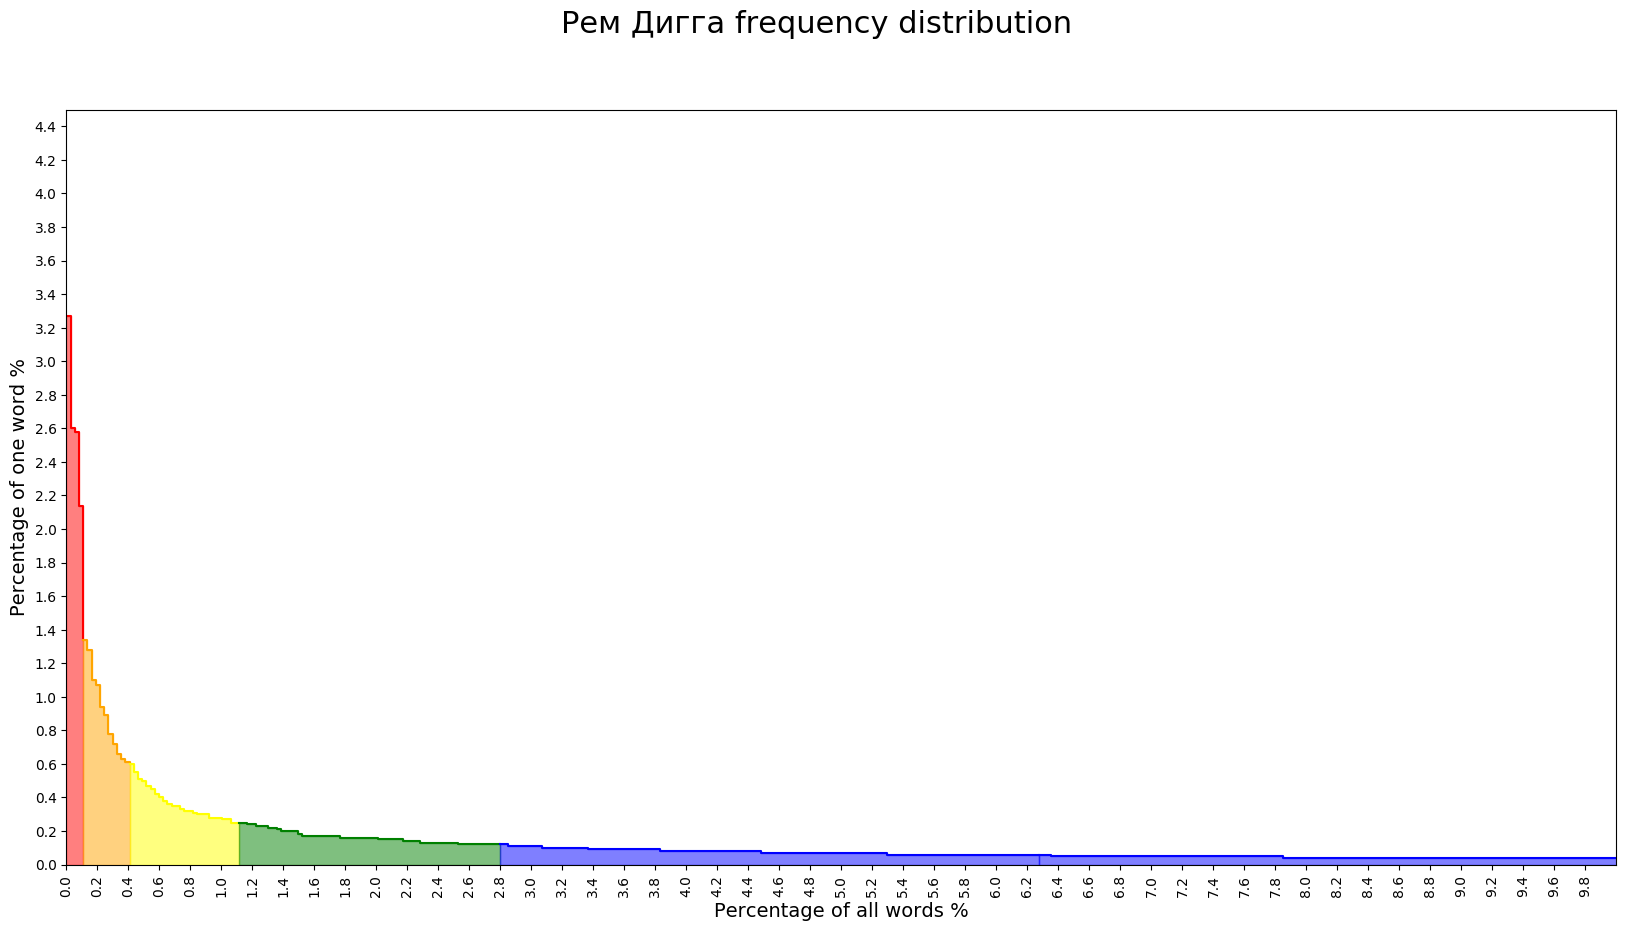

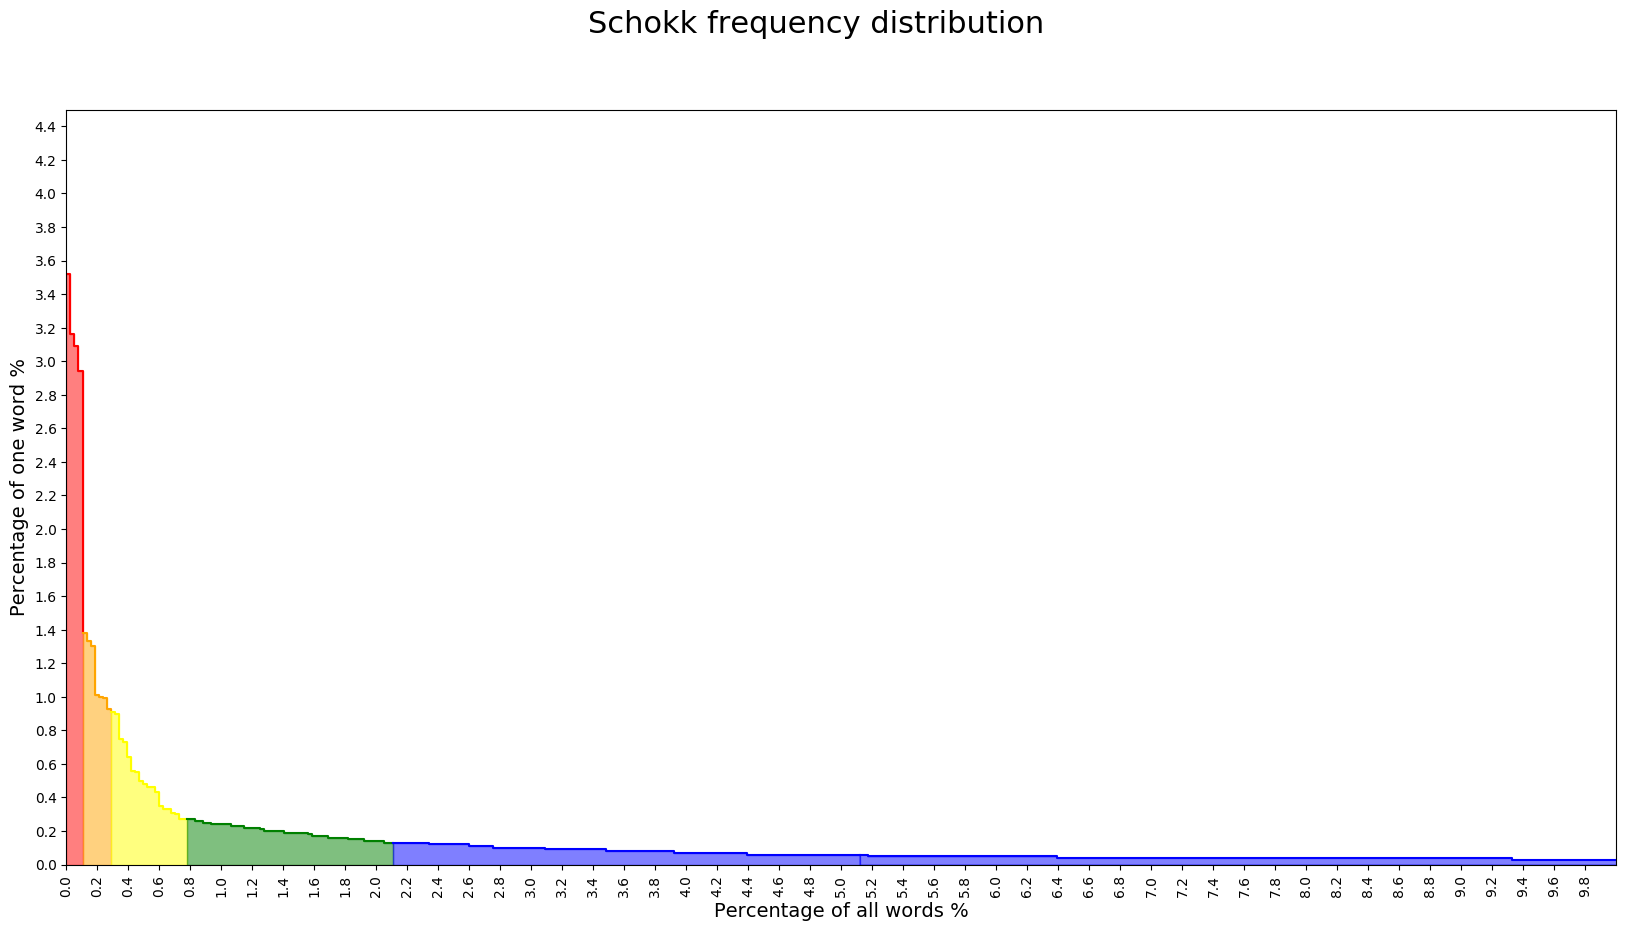

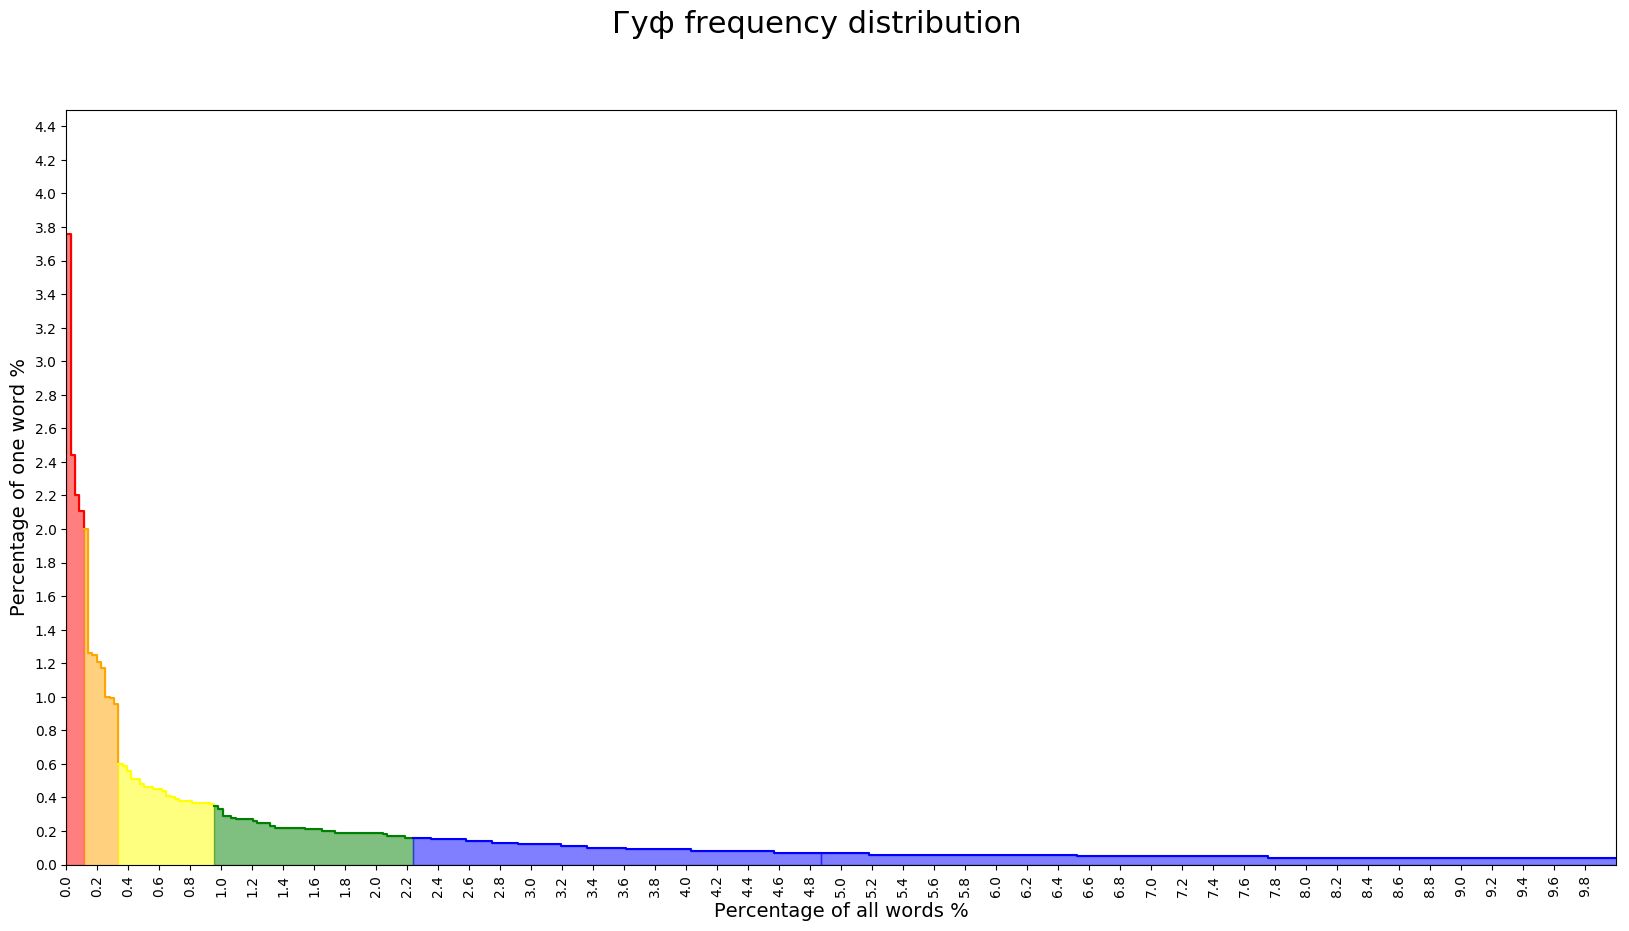

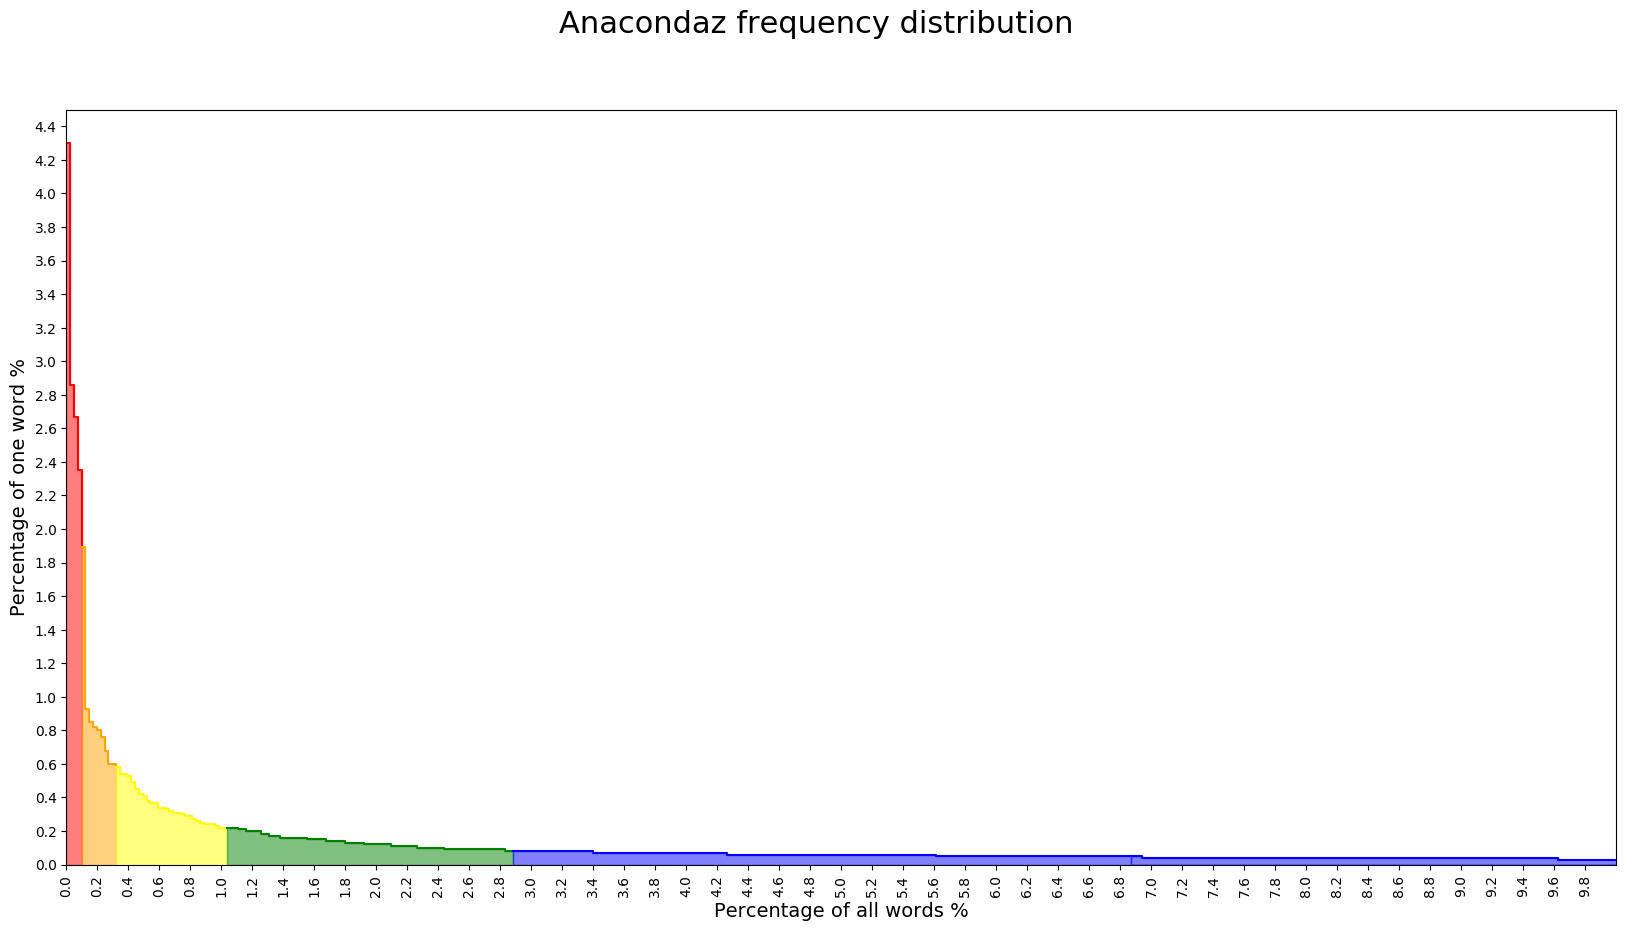

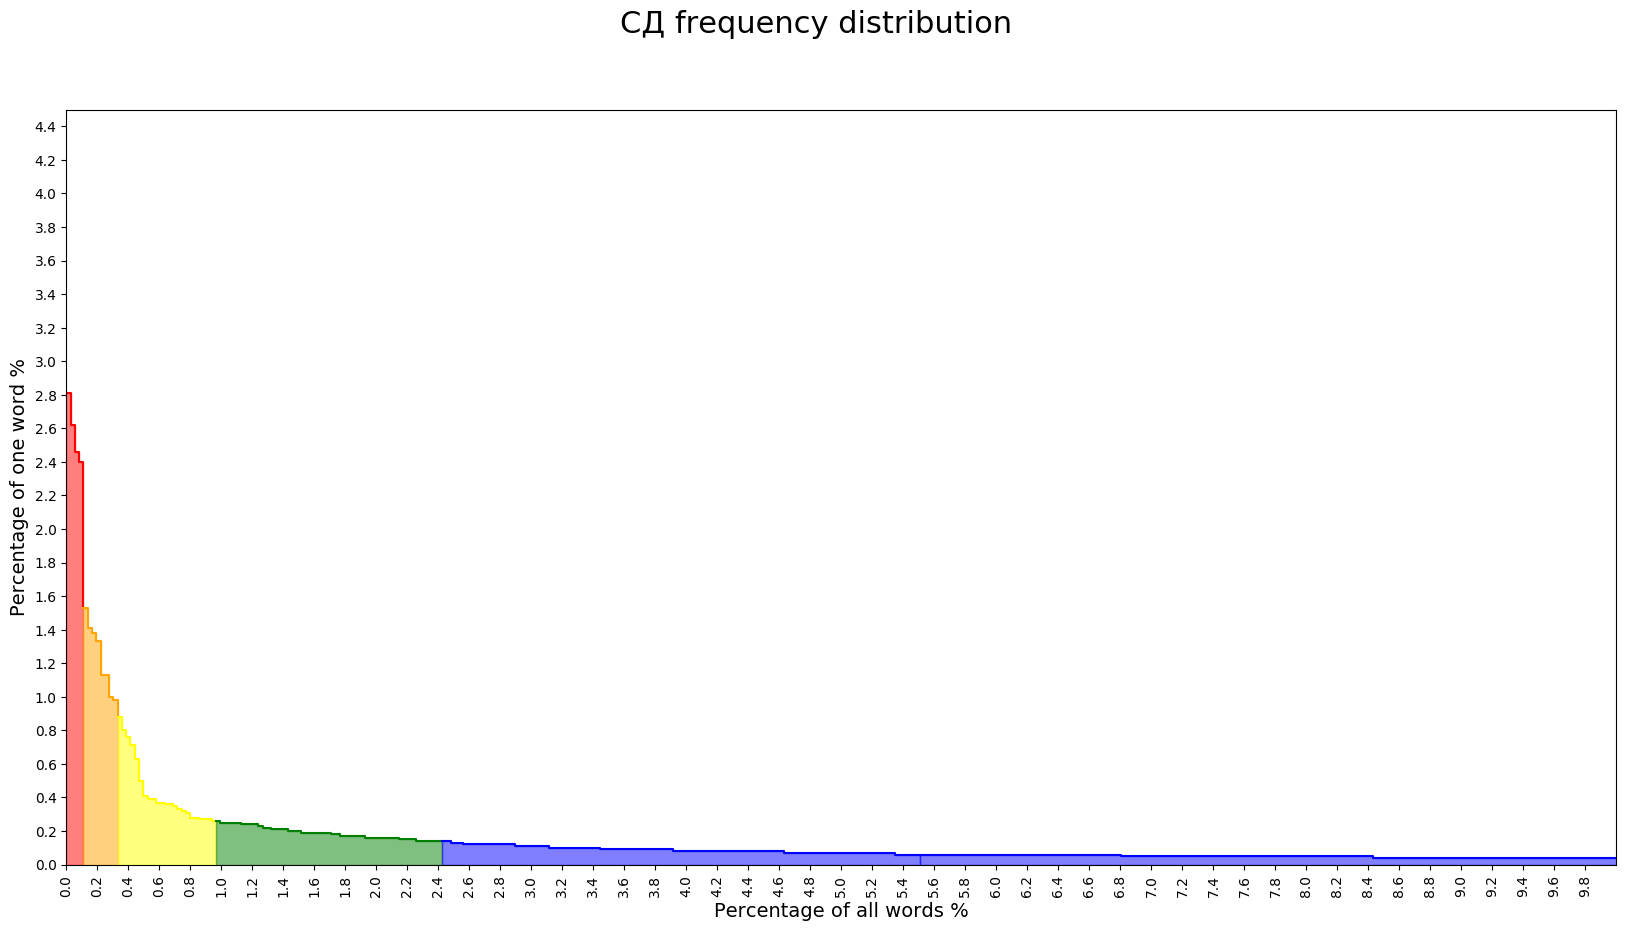

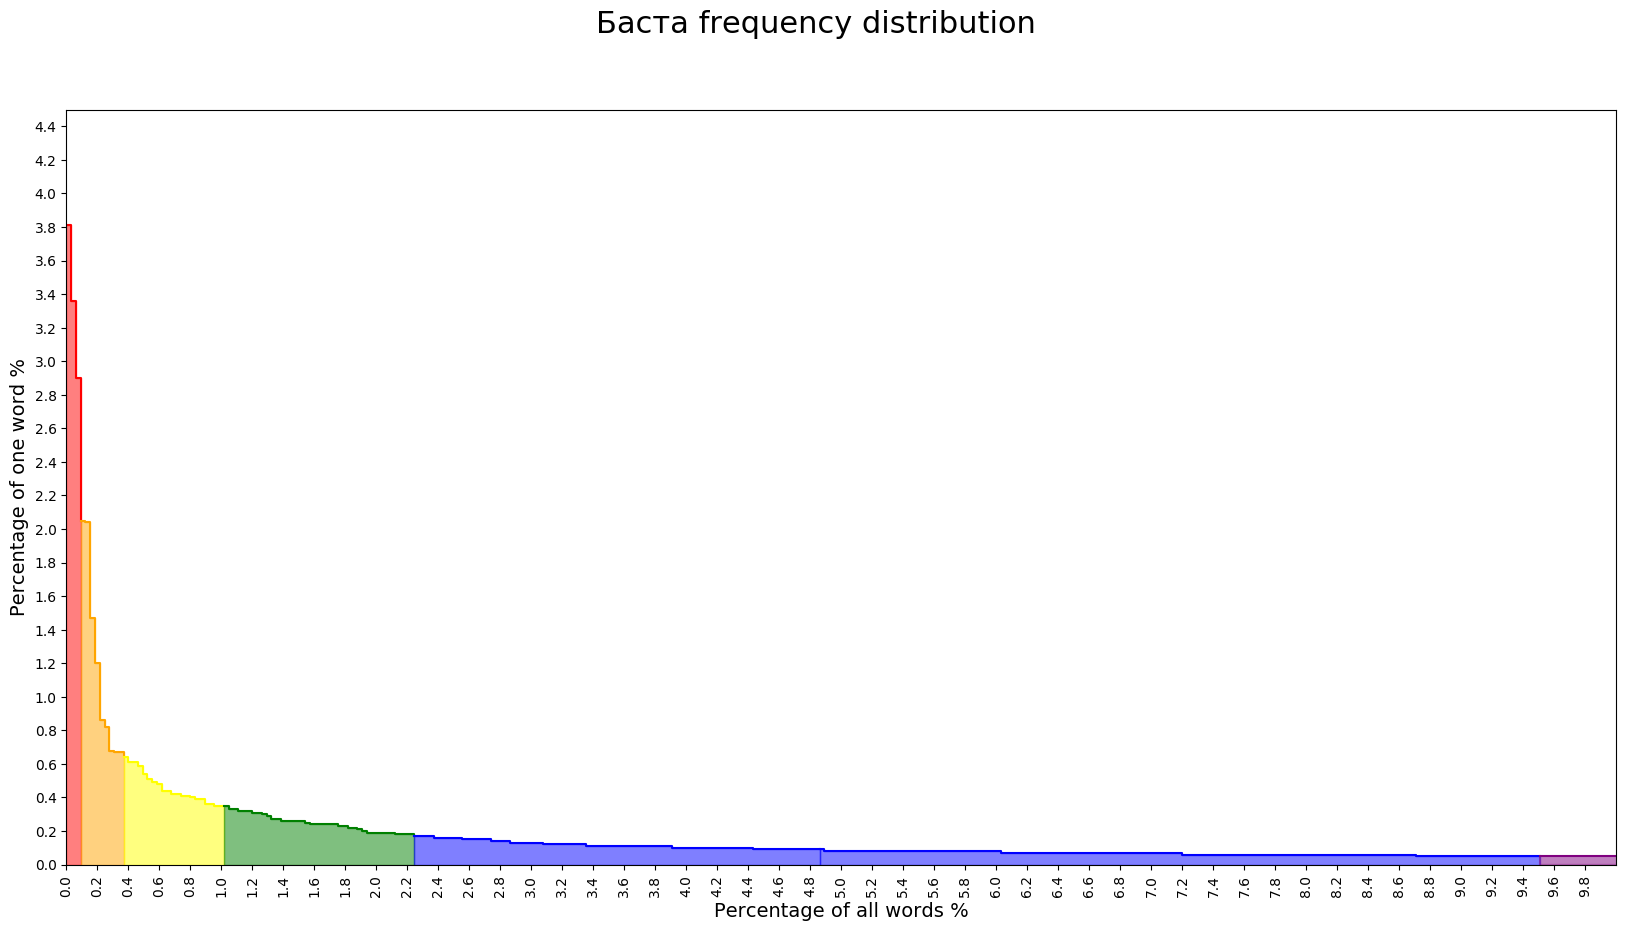

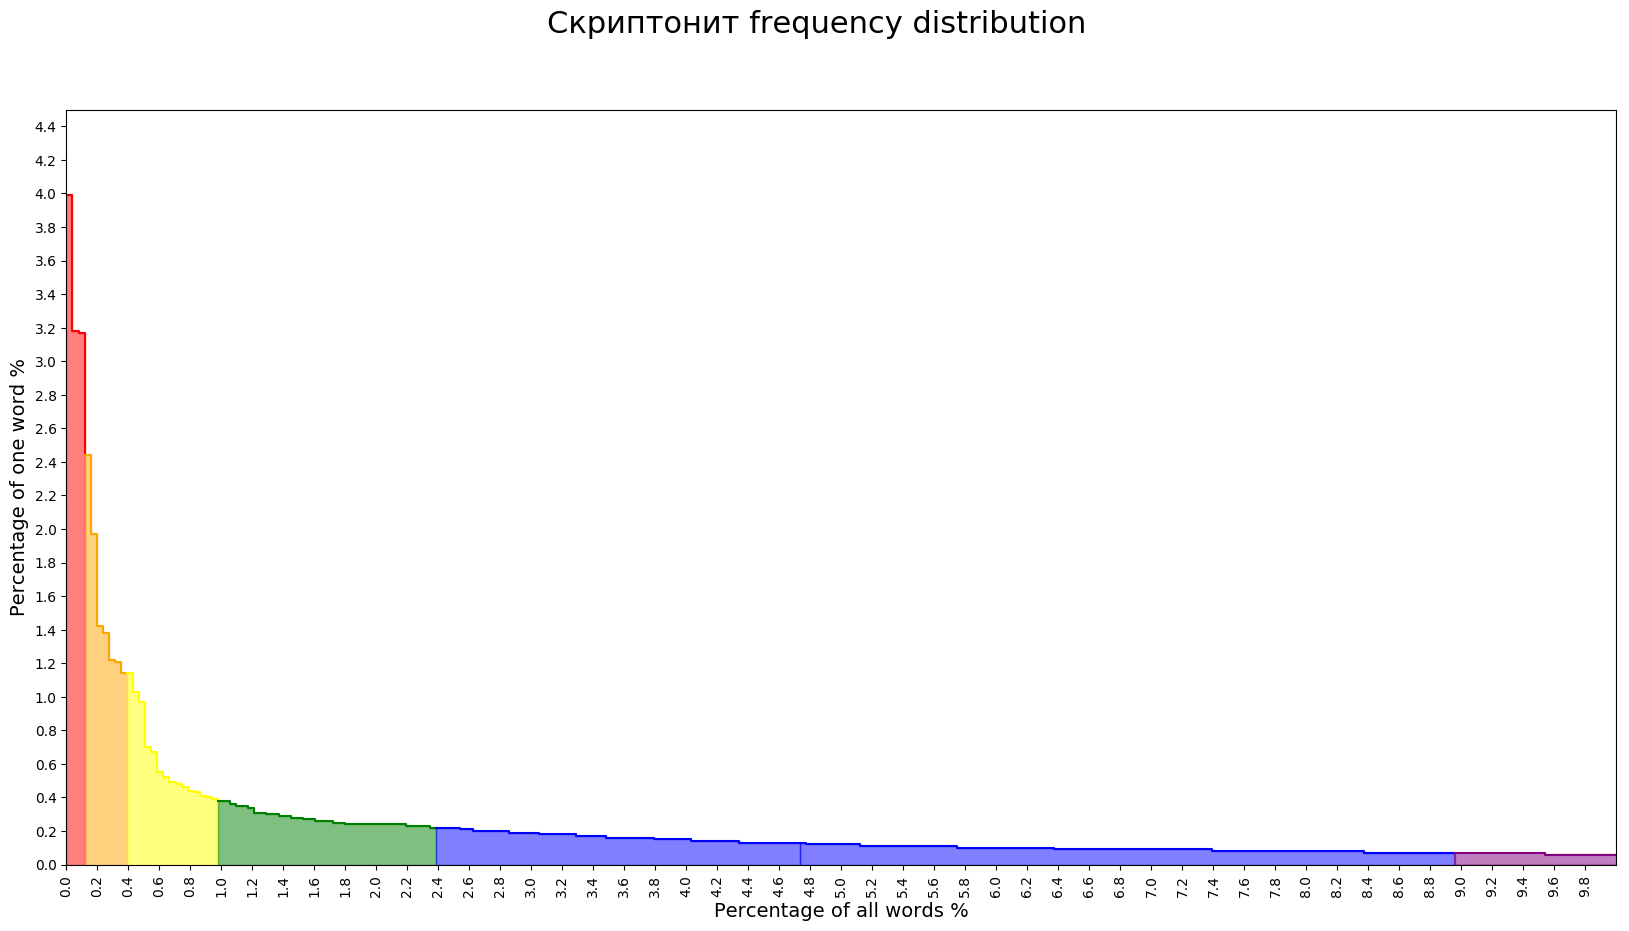

In [13]:
cut_dir.plot_distributions(savedname=True, graph_label=True)

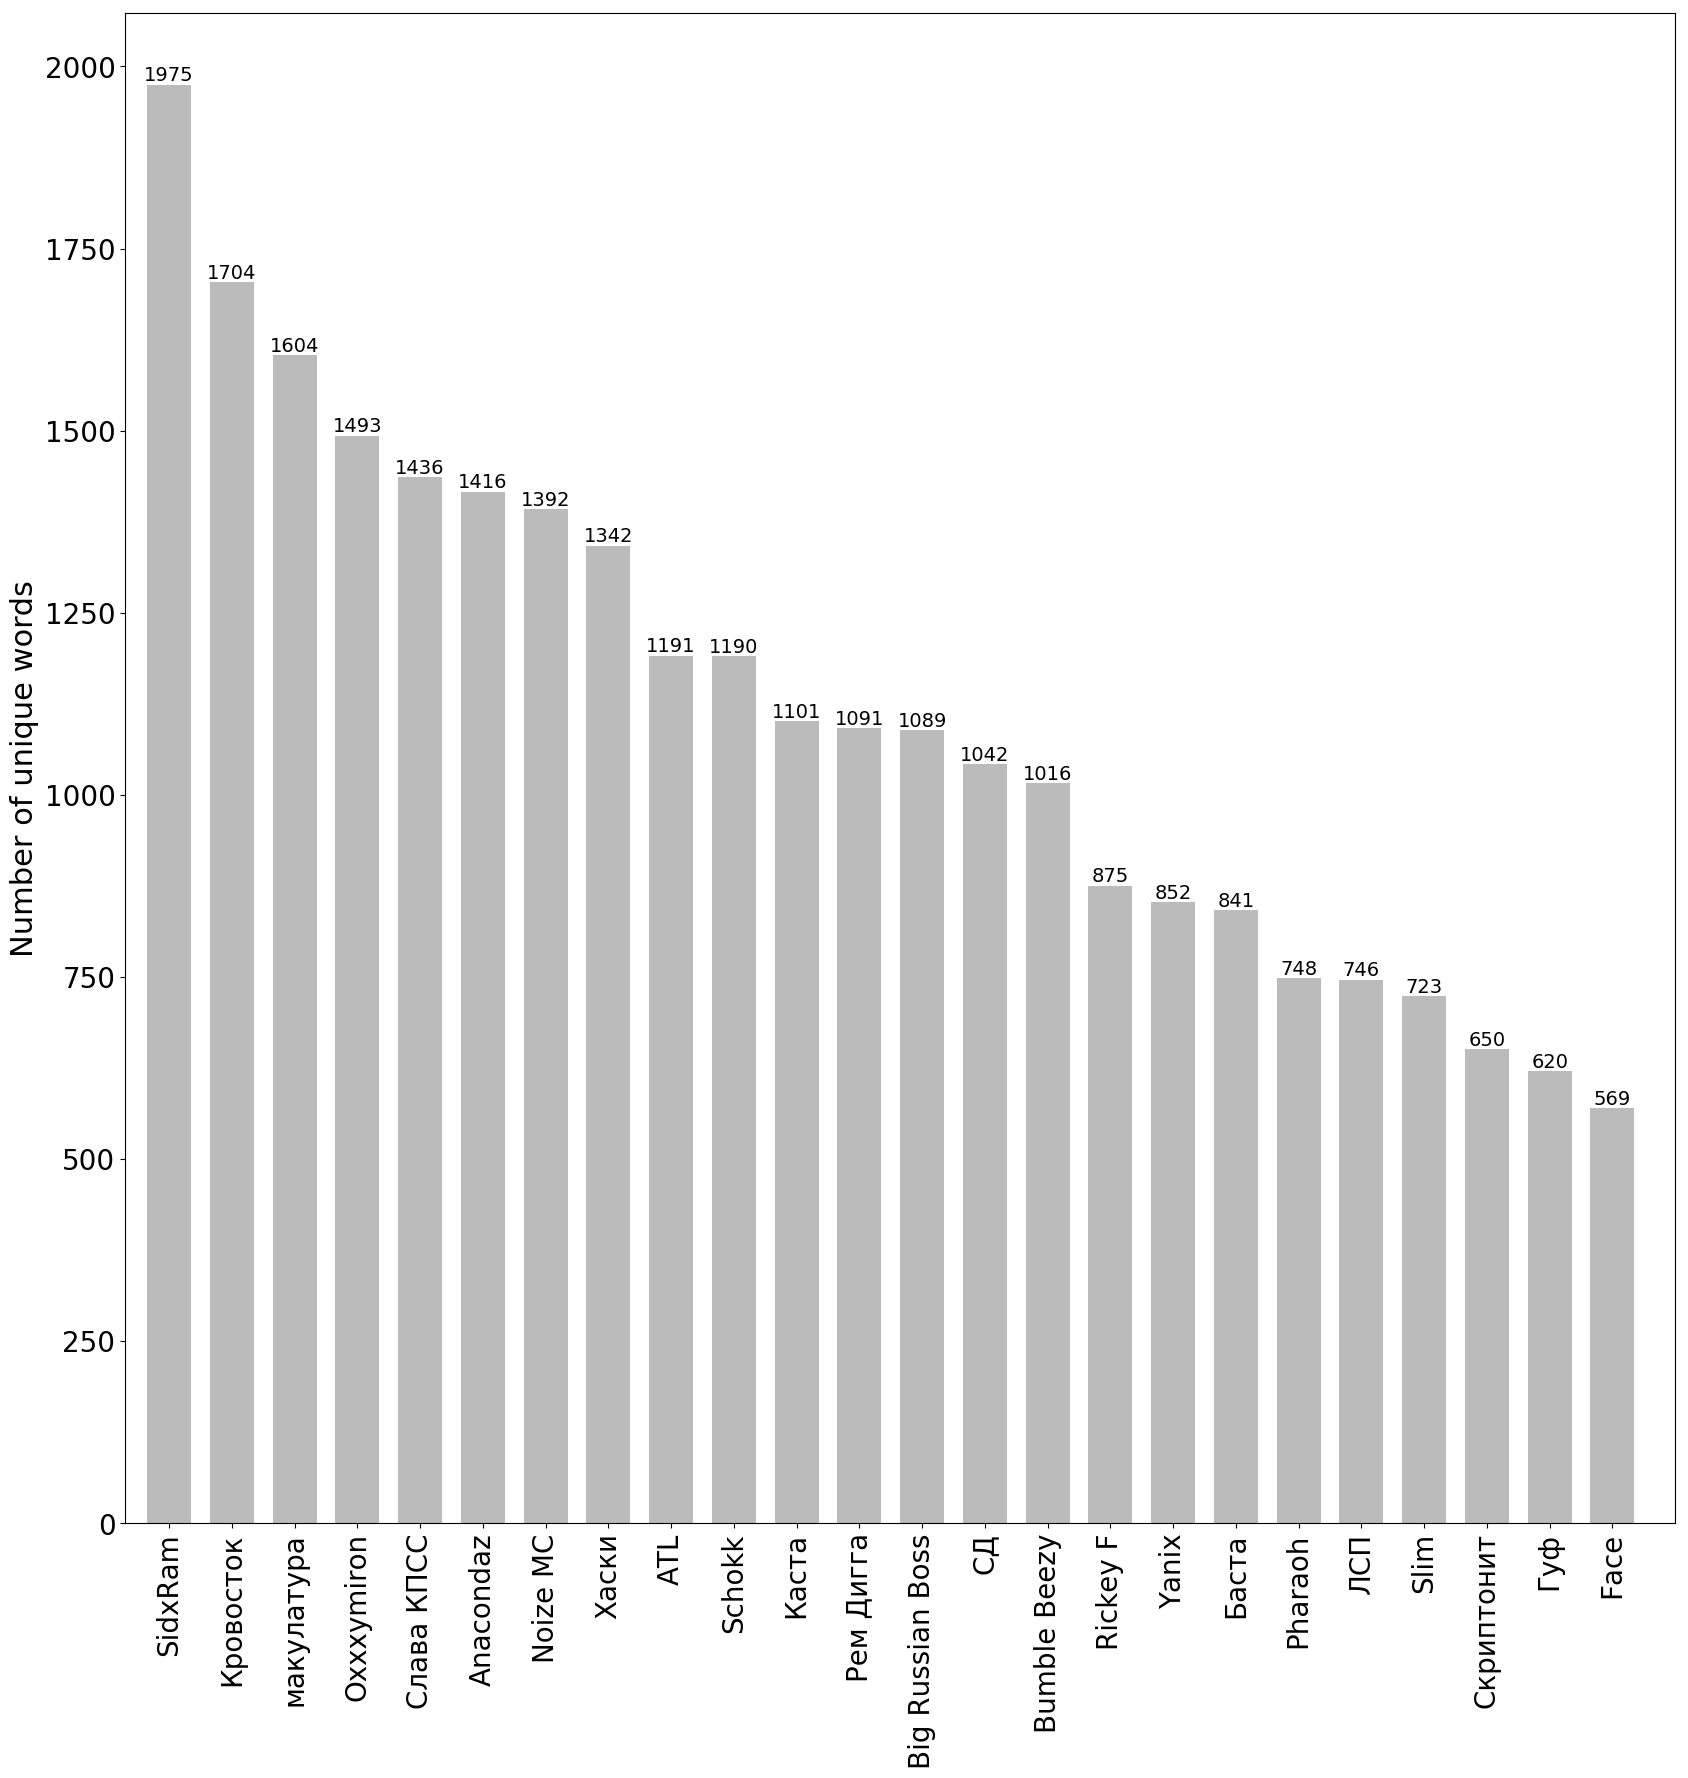

In [14]:
cut_dir.plot_uniq_words('./figs/unique_words.png', y_label="Number of unique words")

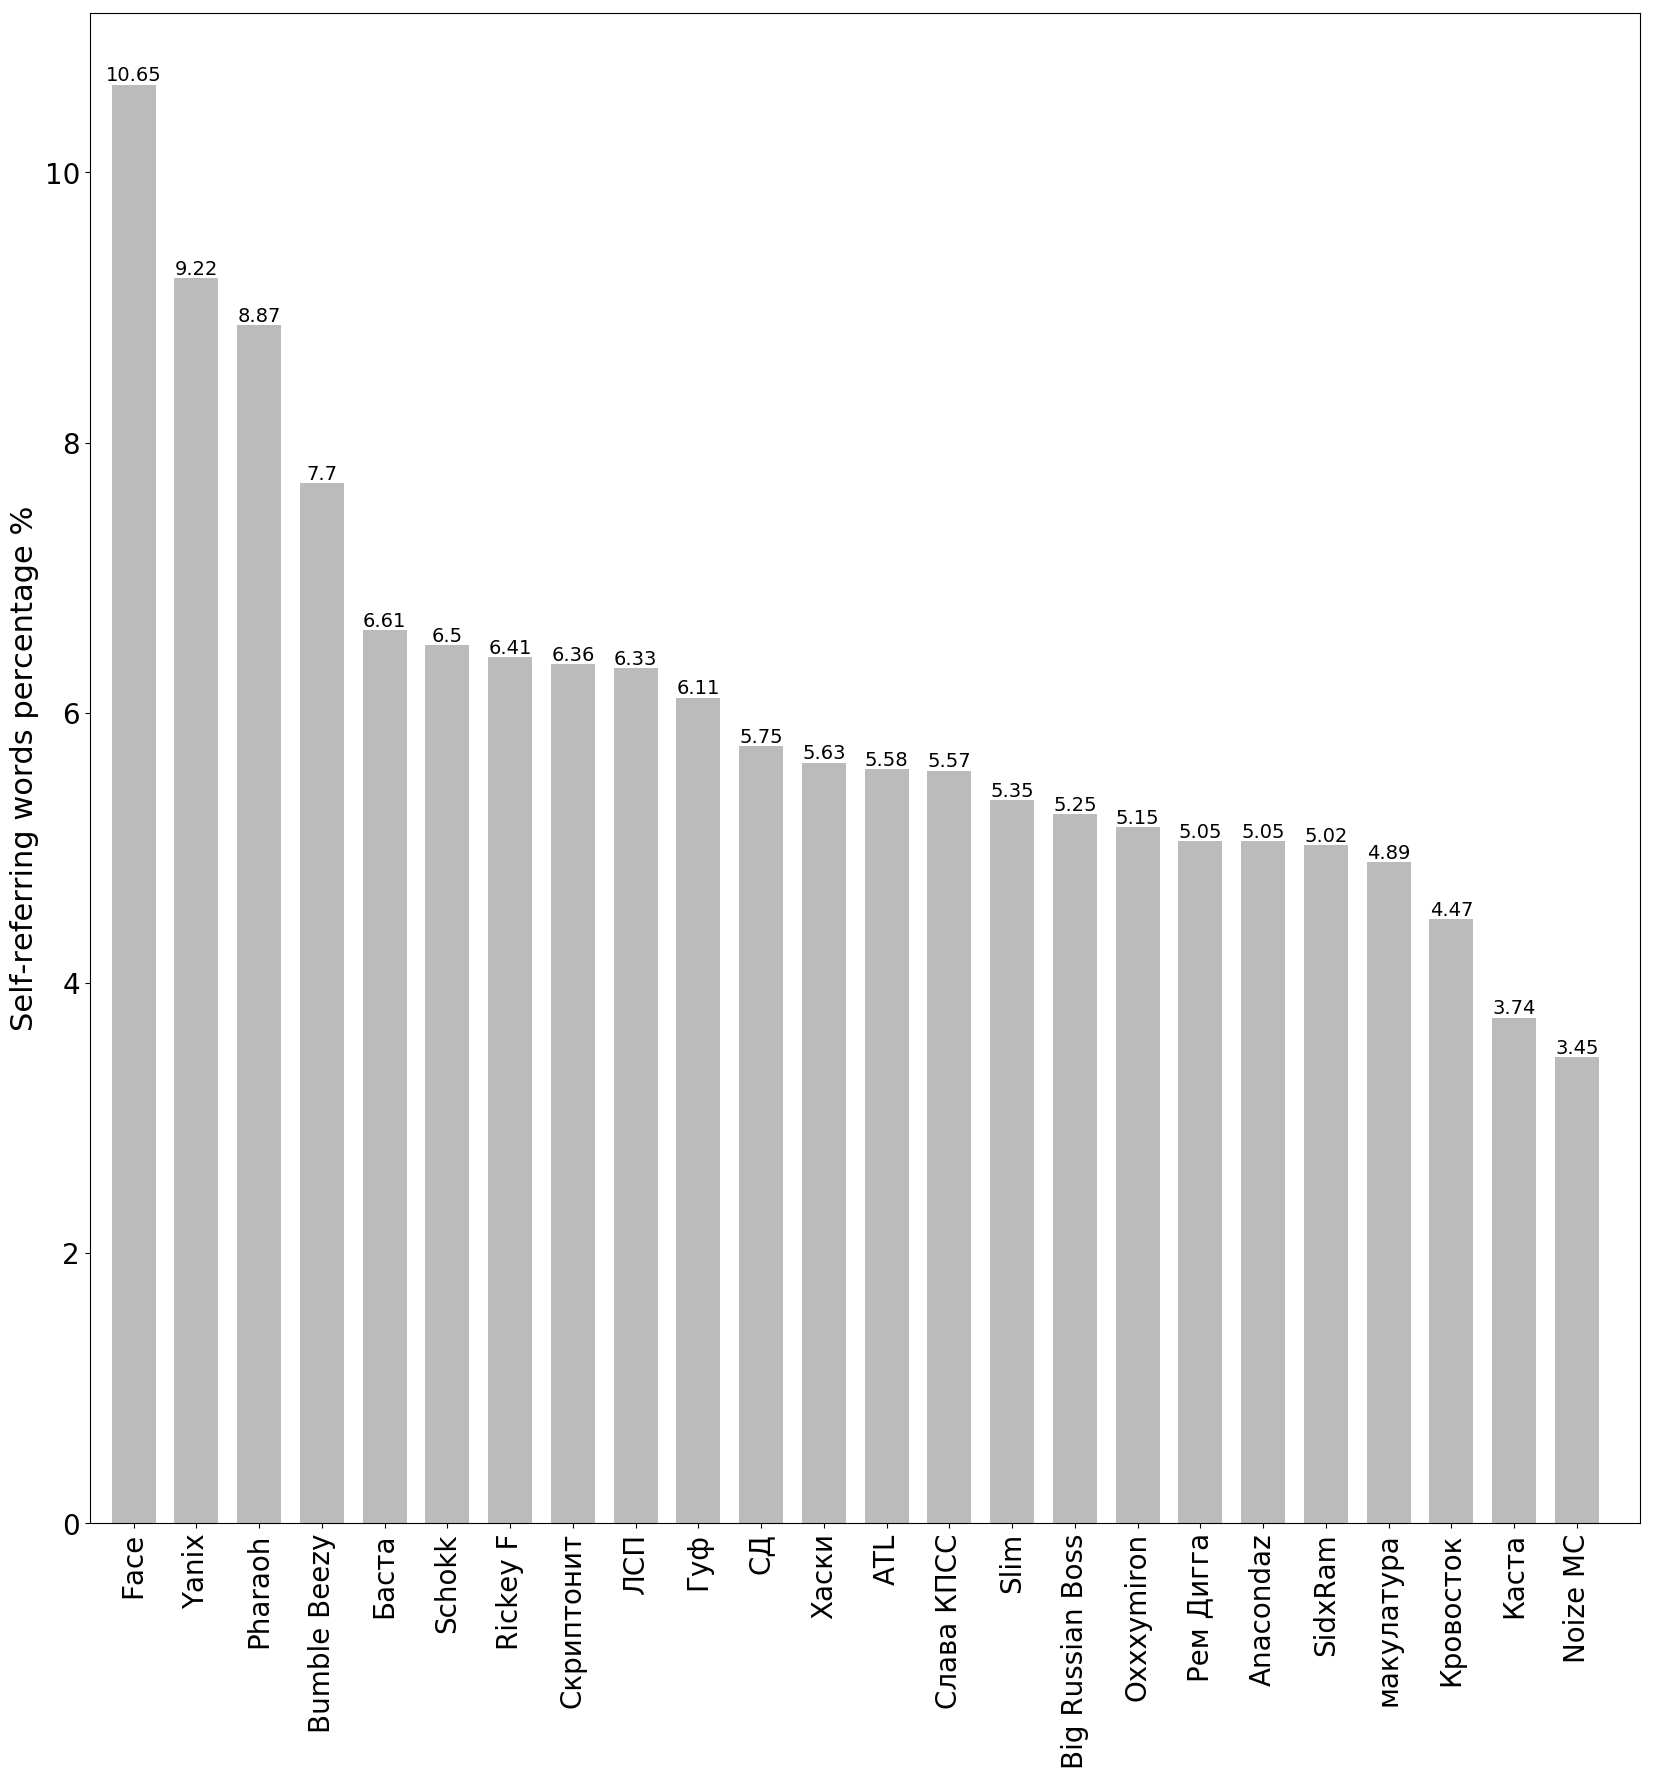

In [15]:
self_referring_words = ["я", "мой", "мы", "мне", "меня", "мои", "нас", "мое", "наше", "моя"]
cut_dir.plot_wordgroup(self_referring_words,
           './figs/self_love.png', 
           y_label="Self-referring words percentage %")

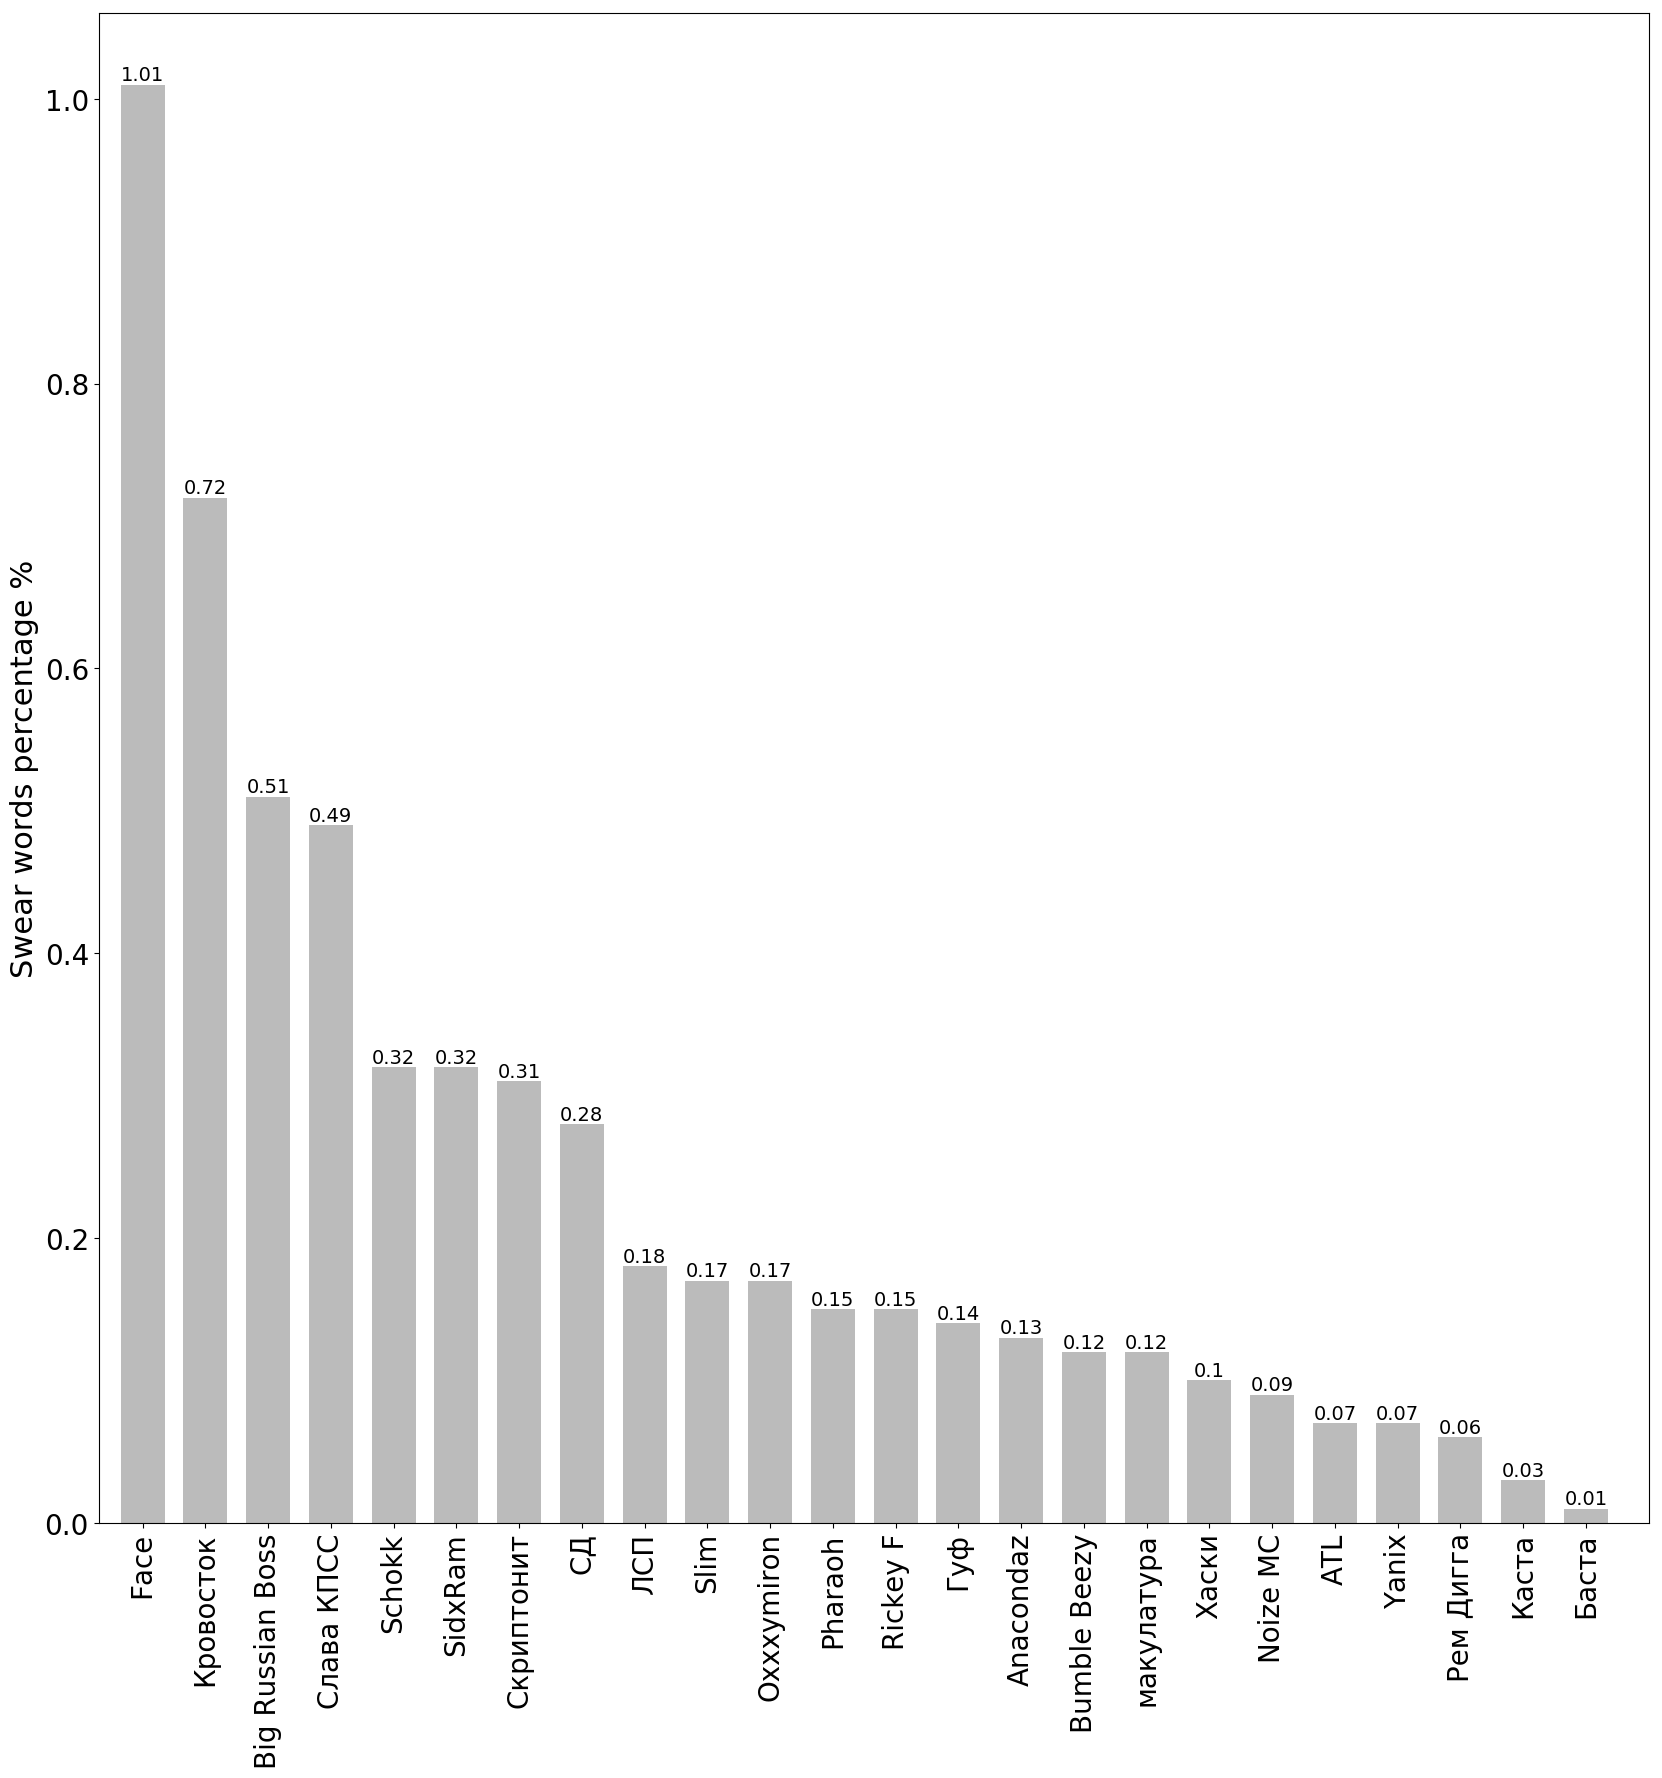

In [16]:
swear_words = ["блядь", "хуй", "ебать", "пиздец", "пизда", "ебал", "пидор", "говно", "хуево"]
cut_dir.plot_wordgroup(swear_words,
           './figs/swear_words.png', 
           y_label="Swear words percentage %")